# CONDENSED NEAREST NEIGHBORS and SEQUENCE MINING

## Libraries

In [125]:
import keras
from keras.datasets import mnist
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.metrics import pairwise_distances_argmin
import cv2
import time
import glob2
import random
import pickle
import kmedoids
from collections import defaultdict
from fuzzywuzzy import fuzz
import freeman as fm
import freeman_noise as fmn
import edit_distance as ed

# Data Preparation

#### Loading MNIST

In [718]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Train data shape: {0} | Train label shape: {1}".format(x_train.shape, y_train.shape))
print("Test data shape:  {0} | Test label shape:  {1}".format(x_test.shape, y_test.shape))

Train data shape: (60000, 28, 28) | Train label shape: (60000,)
Test data shape:  (10000, 28, 28) | Test label shape:  (10000,)


In [719]:
num_classes = len(np.unique(y_train))
print("Total classes: {}".format(num_classes))

Total classes: 10


#### Loading our own data

Loading our handwritten digit images and processed by scalling, converting to greyscale.

In [104]:
def process_image(file_name):
    image = cv2.imread(file_name, 0)
    image_resize = cv2.resize(image, (26,26))
    new_image = cv2.copyMakeBorder(image_resize, 1,1,1,1, cv2.BORDER_CONSTANT, value=[255,255,255])
    invert_image = cv2.bitwise_not(new_image)
    return invert_image

def load_images(img_path, num_classes):
    img_list = []
    label_list = []
    for i in range(0, num_classes):
        file_list = glob2.glob((img_path.format(i)))
        for file in file_list:
            label_list.append(i)
            image = process_image(file)
            image_reshape = image.reshape(1, 28, 28)
            img_list.append(image_reshape)

    num_image = len(img_list)
    my_stack = np.zeros((num_image, 28, 28))
    for j in range(num_image):
        my_stack[j] = img_list[j]

    label_reshape = np.asarray(label_list)
    return my_stack, label_reshape

In [108]:
train_path = "./data/train/{}/*.jpeg"
test_path = "./data/test/{}/*.jpeg"

train_stack, train_lbl = load_images(train_path, num_classes=10)
test_stack, test_lbl = load_images(test_path, num_classes=10)

In [109]:
train_stack.shape, train_lbl.shape

((500, 28, 28), (500,))

#### Reshape for visualization

In [722]:
x_train_all = np.concatenate((x_train,train_stack))
x_test_all = np.concatenate((x_test,test_stack))
y_train_all = np.concatenate((y_train,train_lbl))
y_test_all = np.concatenate((y_test, test_lbl))

In [723]:
x_train_all.shape,y_train_all.shape,x_test_all.shape,y_test_all.shape

((60500, 28, 28), (60500,), (10200, 28, 28), (10200,))

In [724]:
x_train_all_reshape = x_train_all.reshape((len(x_train_all), np.prod(x_train_all.shape[1:])))
x_test_all_reshape = x_test_all.reshape((len(x_test_all), np.prod(x_test_all.shape[1:])))

In [725]:
(x_train_all_reshape.shape, x_test_all_reshape.shape,y_train_all.shape)

((60500, 784), (10200, 784), (60500,))

Load test set of our 200 hand drawing digits for testing freeman code and KNN later

In [110]:
# Test set of our own hand drawing digits which will be used later for testing accuracy of KNN
test_stack_reshape = test_stack.reshape((len(test_stack), np.prod(test_stack.shape[1:])))

In [111]:
test_stack.shape,test_stack_reshape.shape

((200, 28, 28), (200, 784))

In [112]:
my_train_reshape = test_stack.reshape((len(test_stack), np.prod(test_stack.shape[1:])))

In [113]:
my_train_reshape.shape

(200, 784)

#### Normalization

Next, we have to normalize data by dividing each value to 255.

In [29]:
def normalize_data(input_data):
    data = input_data.astype(np.float32)
    return np.multiply(data, 1.0/255.0)

Normalization for MNIST data

In [30]:
x_train_all_norm = normalize_data(x_train_all_reshape)
x_test_all_norm = normalize_data(x_test_all_reshape)
print("Normalization is done.")

Normalization is done.


## PCA

In [204]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_train_all_reshape)

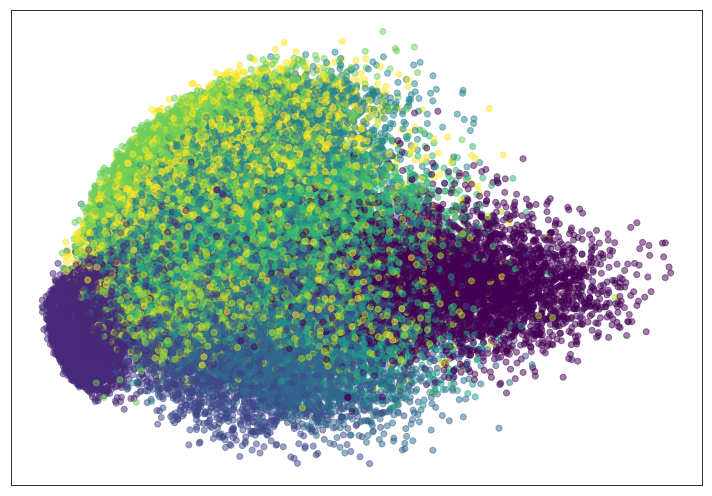

In [205]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_train_all_reshape)
fig, plot = plt.subplots(figsize=(10, 7))
plot.scatter(x_pca[:, 0], x_pca[:, 1], c=y_train_all, cmap='viridis', alpha=.5)
plot.set_xticks(())
plot.set_yticks(())
plt.tight_layout()

# CONDENSED NEAREST NEIGHBORS

First, we apply CNN algorithm to reduce our original dataset (MNIST + own hand drawing data) into a smaller one to use for KNN later.

In [226]:
cnn = CondensedNearestNeighbour(sampling_strategy='auto',random_state=123)
X_resampled, y_resampled = cnn.fit_resample(x_train_all_reshape, y_train_all)

In [227]:
X_resampled.shape, np.unique(y_resampled)

((8399, 784), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [51]:
for i in range(10):
    print("class: ",i,len(X_resampled[y_resampled==i]))

class:  0 201
class:  1 56
class:  2 240
class:  3 791
class:  4 160
class:  5 5471
class:  6 284
class:  7 116
class:  8 804
class:  9 276


In [228]:
#np.save('./data/X_resampled_auto', X_resampled)
#np.save('./data/y_resampled_auto', y_resampled)

In [76]:
#X_resampled = np.load('./data/X_resampled_auto.npy')
#y_resampled = np.load('./data/y_resampled_auto.npy')

Due to the very imbalanced number of digits per class, I decided to do the CNN again to specificly reduce data for class 5.

In [108]:
cnn = CondensedNearestNeighbour(sampling_strategy='all',random_state=456)
X_resampled_new, y_resampled_new = cnn.fit_resample(X_resampled, y_resampled)

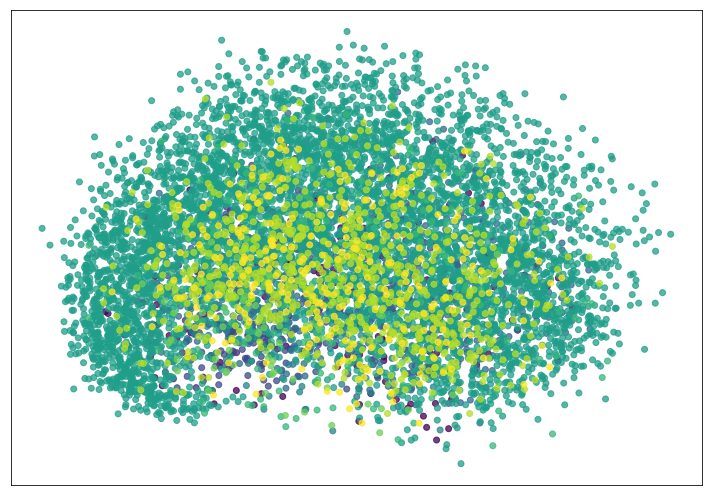

In [231]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(X_resampled)
pca = PCA(n_components=2)
x_pca = pca.fit_transform(X_resampled)
fig, plot = plt.subplots(figsize=(10, 7))
plot.scatter(x_pca[:, 0], x_pca[:, 1], c=y_resampled, cmap='viridis', alpha=.75)
plot.set_xticks(())
plot.set_yticks(())
plt.tight_layout()

In [233]:
cnn = CondensedNearestNeighbour(sampling_strategy='majority',random_state=123)
X_resampled_1, y_resampled_1 = cnn.fit_resample(X_resampled, y_resampled)

In [250]:
#np.save('./data/X_resampled_auto_5', X_resampled_1)
#np.save('./data/y_resampled_auto_5', y_resampled_1)

In [241]:
X_resampled_1.shape, np.unique(y_resampled_1)

((3037, 784), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [79]:
X_resampled = np.load('./data/X_resampled_auto_5.npy')
y_resampled = np.load('./data/y_resampled_auto_5.npy')

In [82]:
class_item = []
for i in range(10):
    num_item = len(y_resampled[y_resampled==i])
    class_item.append(num_item)
    print("class: ",i,len(y_resampled[y_resampled==i]))

class:  0 201
class:  1 56
class:  2 240
class:  3 791
class:  4 160
class:  5 109
class:  6 284
class:  7 116
class:  8 804
class:  9 276


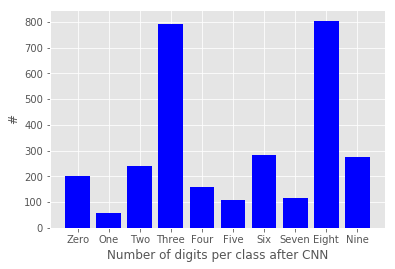

In [101]:
x = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
x_item = [i for i, _ in enumerate(x)]
plt.bar(x_item, class_item, color='blue')
plt.xlabel("Number of digits per class after CNN")
plt.ylabel("#")
plt.xticks(x_item, x)
plt.show()

# Convert to freeman code

In [116]:
def convert_to_freeman(X, mode='normal'):
    freeman_lst = []
    for i in range(X.shape[0]):
        img = X[i].reshape(28, 28)
        fml, _ = fm.freeman_chain_code(np.float32(img),mode)
        fm_code = ''.join(fml)
        freeman_lst.append(fm_code)
        #print("i=",i,"\n",fm_code)
    return freeman_lst

#### Convert our Condensed dataset to Freeman code:

In [94]:
X_resampled = np.load('./data/X_resampled_auto_5.npy')
y_resampled = np.load('./data/y_resampled_auto_5.npy')

In [122]:
freeman_X_resampled = convert_to_freeman(X_resampled)

In [992]:
#np.save("./data/freeman_X_resampled",freeman_X_resampled)

In [123]:
len(freeman_X_resampled)

3037

#### Convert our hand-drawing test dataset to Freeman code:

In [117]:
freeman_X_mydata = convert_to_freeman(my_train_reshape)

In [118]:
len(freeman_X_mydata)

200

## Standard KNN

In [120]:
def knn(test_img, X, y, k, kstrip=10):
    tic = time.time()
    distances = []
    for image in X:
        distances.append(ed.edit_distance(test_img, image, kstrip).cal_distance()[0].astype(int)) 
    cls = [y for _,y in sorted(zip(distances, y))[:k]]
    counter = collections.Counter(cls)
    toc = time.time()
    print("Time: ", toc-tic)
    return counter.most_common(1)[0][0], toc-tic

Test with standard KNN

In [124]:
correct = 0
for idx, image in enumerate(freeman_X_mydata):
    pred, _ = knn(image, freeman_X_resampled, y_resampled, 10, 5)
    if test_lbl[idx] == pred:
        correct +=1
        print("idx= ",idx," # Correct: ",correct,"pred: ",pred," y_test: ", test_lbl[idx])
    else:
        print("idx= ",idx," pred: ",pred," ==WRONG==, actual label: ",test_lbl[idx])

Time:  28.617642879486084
idx=  0  # Correct:  1 pred:  0  y_test:  0
Time:  26.433140993118286
idx=  1  # Correct:  2 pred:  0  y_test:  0
Time:  30.853843927383423
idx=  2  # Correct:  3 pred:  0  y_test:  0
Time:  28.979716062545776
idx=  3  # Correct:  4 pred:  0  y_test:  0
Time:  29.225677013397217
idx=  4  # Correct:  5 pred:  0  y_test:  0
Time:  28.237499952316284
idx=  5  # Correct:  6 pred:  0  y_test:  0
Time:  43.93672180175781
idx=  6  # Correct:  7 pred:  0  y_test:  0
Time:  29.56592106819153
idx=  7  # Correct:  8 pred:  0  y_test:  0
Time:  34.68030095100403
idx=  8  # Correct:  9 pred:  0  y_test:  0
Time:  32.68788290023804
idx=  9  # Correct:  10 pred:  0  y_test:  0
Time:  32.75980019569397
idx=  10  # Correct:  11 pred:  0  y_test:  0
Time:  28.624011993408203
idx=  11  # Correct:  12 pred:  0  y_test:  0
Time:  30.482291221618652
idx=  12  # Correct:  13 pred:  0  y_test:  0
Time:  29.821760892868042
idx=  13  # Correct:  14 pred:  0  y_test:  0
Time:  30.717144

Time:  67.69245219230652
idx=  115  pred:  9  ==WRONG==, actual label:  5
Time:  55.15623927116394
idx=  116  pred:  3  ==WRONG==, actual label:  5
Time:  95.10517382621765
idx=  117  pred:  8  ==WRONG==, actual label:  5
Time:  50.62663197517395
idx=  118  pred:  3  ==WRONG==, actual label:  5
Time:  71.09777593612671
idx=  119  # Correct:  90 pred:  5  y_test:  5
Time:  56.59211587905884
idx=  120  # Correct:  91 pred:  6  y_test:  6
Time:  68.7166862487793
idx=  121  # Correct:  92 pred:  6  y_test:  6
Time:  65.58994817733765
idx=  122  # Correct:  93 pred:  6  y_test:  6
Time:  64.2619252204895
idx=  123  # Correct:  94 pred:  6  y_test:  6
Time:  87.53285717964172
idx=  124  # Correct:  95 pred:  6  y_test:  6
Time:  50.01733684539795
idx=  125  # Correct:  96 pred:  6  y_test:  6
Time:  45.413804054260254
idx=  126  # Correct:  97 pred:  6  y_test:  6
Time:  39.70300817489624
idx=  127  # Correct:  98 pred:  6  y_test:  6
Time:  44.50260782241821
idx=  128  # Correct:  99 pred: 

After running, we got 165/200 correct examples on test set with accuracy of 82.5 %

## Speed up KNN

#### Algorithm

I applied the algorithm in first semester lecture to speed up KNN by randomly picking up 2 examples and remove examples that satisfy the condition: 
      - less than cost1-cost2 or greater than cost1+cost2
with `cost1, cost2` are the distances from our two random examples to our test example respectively.

#### Cost Matrix

Cost matrix is used to remove items that are not satified the cost condition as described above.

In [67]:
def build_dist_mat(X_freeman, kstrip=5):
    length = len(X_freeman)
    dist_mat = np.zeros((length,length))
    for i in range(length):
        for j in range(length):
            dist = ed.edit_distance(X_freeman[i], X_freeman[j], kstrip).cal_distance()[0].astype(int)
            #if dist <=0:
                #print("i=", i, " j=", j," dist: ",dist)
            dist_mat[i][j] = dist
    return dist_mat

In [68]:
dist_mat = build_dist_mat(freeman_X_resampled,kstrip=10)

In [71]:
#np.save('./data/dist_mat_new',dist_mat)

In [72]:
dist_mat = np.load('./data/dist_mat_new.npy')

In [73]:
(dist_mat.shape)

(3037, 3037)

In [74]:
dist_mat

array([[ 0., 17., 19., ..., 62., 35., 46.],
       [17.,  0., 19., ..., 56., 27., 50.],
       [19., 19.,  0., ..., 52., 33., 55.],
       ...,
       [62., 56., 52., ...,  0., 47., 38.],
       [35., 27., 33., ..., 47.,  0., 40.],
       [46., 50., 55., ..., 38., 40.,  0.]])

Function to apply the algorithm:

In [585]:
def remove_items(large_cost, small_cost, matrix_row, X, y):
    new_X, new_y = [],[]
    c_1 = large_cost - small_cost
    c_2 = large_cost + small_cost
    print(c_1, c_2)
    idx = []
    for i in range(matrix_row.shape[0]):
        if matrix_row[i] < c_1 or matrix_row[i] > c_2:
            idx.append(i)
    new_X = X[:]
    new_y = y[:].tolist()
    for index in idx:
        new_X.remove(X[index])
        new_y.remove(y[index])
    return new_X, new_y

In [983]:
def faster_knn(distance_matrix, test_example, X_freeman, y,kstrip=10, nn=5):
    #set_trace()
    rd = random.sample(range(0,distance_matrix.shape[0]), 2)
    cost1 = ed.edit_distance(test_example, X_freeman[rd[0]], kstrip).cal_distance()[0].astype(int)
    cost2 = ed.edit_distance(test_example, X_freeman[rd[1]], kstrip).cal_distance()[0].astype(int)
    if cost1 <0 or cost2 <0:
        len1 = len(X_freeman[rd[0]])
        len2 = len(X_freeman[rd[1]])
        len_ = min(len1,len2)
        kstrip = np.floor(len_/2)
        cost1 = ed.edit_distance(test_example, X_freeman[rd[0]], kstrip).cal_distance()[0].astype(int)
        cost2 = ed.edit_distance(test_example, X_freeman[rd[1]], kstrip).cal_distance()[0].astype(int)
    print("cost1 ", cost1, "cost2 ", cost2)
    new_X, new_y  =[],[]
    if cost1 > cost2:
        matrix_row = distance_matrix[rd[0],:]
        new_X, new_y = remove_items(cost1, cost2, matrix_row, X_freeman, y)
    else:
        matrix_row = distance_matrix[rd[1],:]
        new_X, new_y = remove_items(cost2, cost1, matrix_row, X_freeman, y)
    print(len(new_X))
    
    if len(new_X) > 0:
        pred, time = knn(test_example, new_X, new_y, kstrip)
    else:
        pred , time= knn(test_example, X_freeman, y)
        print("empty list")
    return pred, time

Function to test accuracy of standard KNN+freeman code and the speed-up version

In [496]:
def predict_freeman(distance_matrix, X_train, y_train, X_test, y_test, kstrip=10, nn=5):
    correct = 0
    for i in range(len(X_test)):
        pred,_ = faster_knn(distance_matrix, X_test[i], freeman_X_resampled, y_resampled, kstrip, nn)
        if pred == y_test[i]:
            correct +=1
            print("i=",i," # Correct: ",correct,"pred: ",pred," y_test: ", y_test[i])
        else:
            print("i=",i,"pred: ",pred," Wrong, actual label: ",y_test[i])
    print("Accuracy: ", (correct/len(X_test))*100)

Here I used the condensed dataset to test the algorithm. However, because of the randomness, the number of examples that I can remove each time are not significant. It took around 30-60 seconds (depends on the length of the freeman code) to predict one test example which is not practical in this case. So I didn't spend time to use this algorithm and have decided to implement a new method.

## K-means + KNN

Instead of calculating the distance among the test example and all of examples in our dataset, I tried to use K-means to cluster the condensed dataset into 10 different clusters and obviously, the result is not really good because we will have different digits in the same cluster.

When having a new test example, I will calculate the distance of this item with all of the 10 cluster centroids to find out which one is the nearest. Then I pick all examples of that nearest cluster, convert them into freeman code and do the prediction with test item freeman code.

Compared to the standard KNN with freeman code on all examples, this will significantly reduce the processing time by 5-7 times. Unfortunately, there is a trade-off between the speed and accuracy. Sometimes the result is not as good as the prediction on all examples which makes sense to us.

In [986]:
# Ref: https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
def find_clusters(X, num_cluster, seed=123):
    rnd = np.random.RandomState(seed)
    i = rnd.permutation(X.shape[0])[:num_cluster]
    centroids = X[i]
    while True:
        cluster_lbl = pairwise_distances_argmin(X, centroids)
        new_centroids = np.array([X[cluster_lbl == i].mean(0) for i in range(num_cluster)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return centroids, cluster_lbl

In [987]:
c, l = find_clusters(X_resampled, 10, 123)

In [989]:
#np.save("./data/centroids", c)
#np.save("./data/cluster_lbl", l)

In [990]:
def kmeans_knn(test_img, centroids, cluster_lbl, X_freeman, y_label, kstrip=10, nn=5, show=False, fm_mode='normal'):
    # Find nearest centroid of test image (1,784) array
    nearest_centroid = pairwise_distances_argmin(test_img.reshape(1,-1), centroids)
    print("Nearest centroid: ",nearest_centroid)
    # Convert test image to freeman code
    test_img_reshape = test_img.reshape((28, 28))
    if show:
        plt.imshow(test_img_reshape, cmap=cm.binary)
        plt.show()
    test_freeman, _ = fm.freeman_chain_code(np.float32(test_img_reshape),fm_mode)
    test_fm_code = ''.join(test_freeman)
    # Get all freeman of X set and y labels for all examples in nearest cluster
    X_freeman_array = np.asarray(X_freeman)
    new_freeman_cluster = X_freeman_array[cluster_lbl==nearest_centroid]
    new_y_cluster = y_label[cluster_lbl==nearest_centroid]
    # Calculate KNN for test freeman and examples in cluster freemans
    pred, time = knn(test_fm_code, new_freeman_cluster, new_y_cluster, kstrip, nn)
    return pred, time

In [991]:
test_lbl.shape

(200,)

#### Prediction on test set without noise tolerance freeman code:

Nearest centroid:  [6]
Time:  9.03652811050415
idx=  0  # Correct:  1 pred:  0  y_test:  0
Nearest centroid:  [2]
Time:  10.081784009933472
idx=  1  # Correct:  2 pred:  0  y_test:  0
Nearest centroid:  [6]
Time:  8.071335792541504
idx=  2  # Correct:  3 pred:  0  y_test:  0
Nearest centroid:  [9]
Time:  8.105930089950562
idx=  3  # Correct:  4 pred:  0  y_test:  0
Nearest centroid:  [6]
Time:  8.399001836776733
idx=  4  # Correct:  5 pred:  0  y_test:  0
Nearest centroid:  [1]
Time:  10.49547791481018
idx=  5  pred:  8  ==WRONG==, actual label:  0


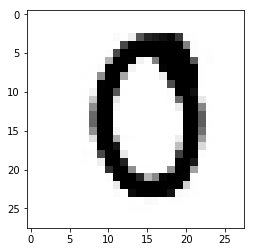

Nearest centroid:  [0]
Time:  10.452195882797241
idx=  6  pred:  6  ==WRONG==, actual label:  0


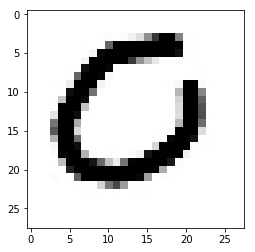

Nearest centroid:  [6]
Time:  8.531594276428223
idx=  7  # Correct:  6 pred:  0  y_test:  0
Nearest centroid:  [6]
Time:  8.516494035720825
idx=  8  pred:  8  ==WRONG==, actual label:  0


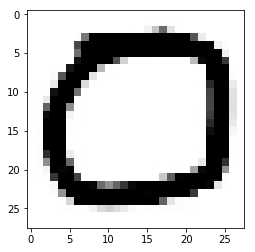

Nearest centroid:  [0]
Time:  7.959717273712158
idx=  9  # Correct:  7 pred:  0  y_test:  0
Nearest centroid:  [6]
Time:  8.130244970321655
idx=  10  # Correct:  8 pred:  0  y_test:  0
Nearest centroid:  [8]
Time:  8.216390132904053
idx=  11  # Correct:  9 pred:  0  y_test:  0
Nearest centroid:  [0]
Time:  7.855647087097168
idx=  12  # Correct:  10 pred:  0  y_test:  0
Nearest centroid:  [0]
Time:  9.20239806175232
idx=  13  # Correct:  11 pred:  0  y_test:  0
Nearest centroid:  [6]
Time:  8.431059122085571
idx=  14  # Correct:  12 pred:  0  y_test:  0
Nearest centroid:  [6]
Time:  9.766122102737427
idx=  15  # Correct:  13 pred:  0  y_test:  0
Nearest centroid:  [6]
Time:  12.53070592880249
idx=  16  pred:  5  ==WRONG==, actual label:  0


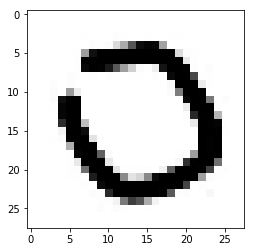

Nearest centroid:  [2]
Time:  19.88810086250305
idx=  17  pred:  6  ==WRONG==, actual label:  0


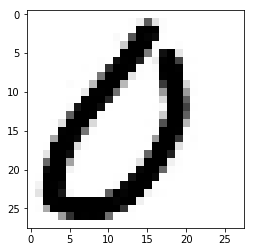

Nearest centroid:  [2]
Time:  10.700555086135864
idx=  18  pred:  8  ==WRONG==, actual label:  0


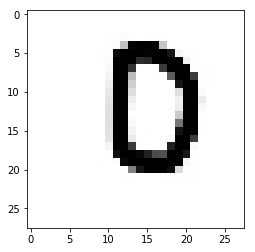

Nearest centroid:  [6]
Time:  8.73815131187439
idx=  19  # Correct:  14 pred:  0  y_test:  0
Nearest centroid:  [2]
Time:  11.93730902671814
idx=  20  # Correct:  15 pred:  1  y_test:  1
Nearest centroid:  [2]
Time:  12.35395884513855
idx=  21  # Correct:  16 pred:  1  y_test:  1
Nearest centroid:  [2]
Time:  15.206464052200317
idx=  22  # Correct:  17 pred:  1  y_test:  1
Nearest centroid:  [1]
Time:  13.673936128616333
idx=  23  pred:  9  ==WRONG==, actual label:  1


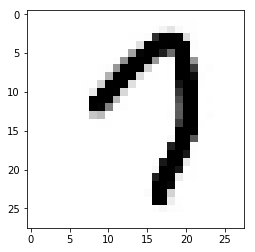

Nearest centroid:  [2]
Time:  11.496806859970093
idx=  24  # Correct:  18 pred:  1  y_test:  1
Nearest centroid:  [2]
Time:  11.048216104507446
idx=  25  # Correct:  19 pred:  1  y_test:  1
Nearest centroid:  [2]
Time:  12.71604609489441
idx=  26  # Correct:  20 pred:  1  y_test:  1
Nearest centroid:  [8]
Time:  11.085782051086426
idx=  27  pred:  8  ==WRONG==, actual label:  1


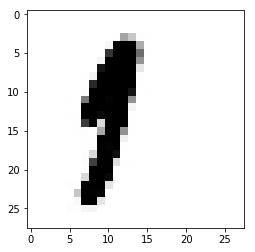

Nearest centroid:  [2]
Time:  16.621251821517944
idx=  28  pred:  9  ==WRONG==, actual label:  1


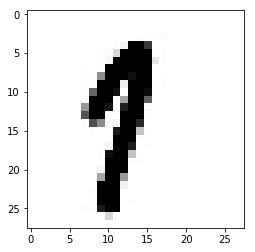

Nearest centroid:  [2]
Time:  14.87556505203247
idx=  29  # Correct:  21 pred:  1  y_test:  1
Nearest centroid:  [2]
Time:  13.03825831413269
idx=  30  # Correct:  22 pred:  1  y_test:  1
Nearest centroid:  [8]
Time:  11.534212112426758
idx=  31  pred:  9  ==WRONG==, actual label:  1


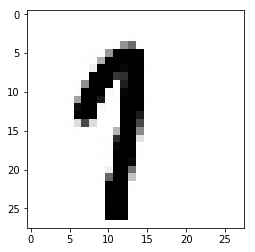

Nearest centroid:  [2]
Time:  13.561445951461792
idx=  32  # Correct:  23 pred:  1  y_test:  1
Nearest centroid:  [2]
Time:  16.055618047714233
idx=  33  pred:  7  ==WRONG==, actual label:  1


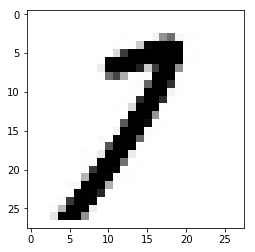

Nearest centroid:  [5]
Time:  13.517002820968628
idx=  34  # Correct:  24 pred:  1  y_test:  1
Nearest centroid:  [2]
Time:  15.722133874893188
idx=  35  # Correct:  25 pred:  1  y_test:  1
Nearest centroid:  [2]
Time:  15.696433305740356
idx=  36  # Correct:  26 pred:  1  y_test:  1
Nearest centroid:  [2]
Time:  12.985656976699829
idx=  37  # Correct:  27 pred:  1  y_test:  1
Nearest centroid:  [2]
Time:  12.08348798751831
idx=  38  pred:  9  ==WRONG==, actual label:  1


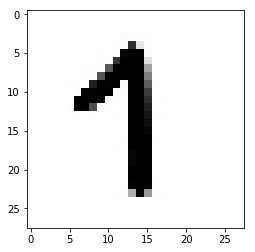

Nearest centroid:  [8]
Time:  10.233925819396973
idx=  39  pred:  9  ==WRONG==, actual label:  1


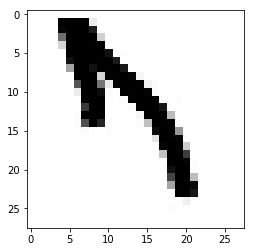

Nearest centroid:  [5]
Time:  9.916367053985596
idx=  40  # Correct:  28 pred:  2  y_test:  2
Nearest centroid:  [0]
Time:  10.958470106124878
idx=  41  # Correct:  29 pred:  2  y_test:  2
Nearest centroid:  [1]
Time:  17.83626914024353
idx=  42  pred:  8  ==WRONG==, actual label:  2


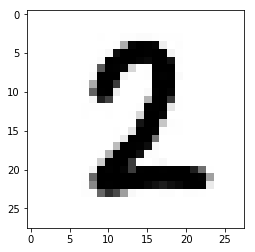

Nearest centroid:  [1]
Time:  17.350565195083618
idx=  43  pred:  9  ==WRONG==, actual label:  2


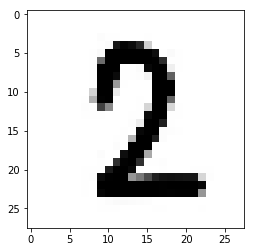

Nearest centroid:  [0]
Time:  13.431793212890625
idx=  44  pred:  5  ==WRONG==, actual label:  2


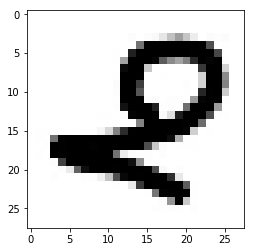

Nearest centroid:  [2]
Time:  17.339186906814575
idx=  45  # Correct:  30 pred:  2  y_test:  2
Nearest centroid:  [6]
Time:  13.482435703277588
idx=  46  pred:  5  ==WRONG==, actual label:  2


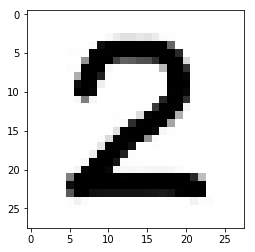

Nearest centroid:  [6]
Time:  10.90450406074524
idx=  47  pred:  5  ==WRONG==, actual label:  2


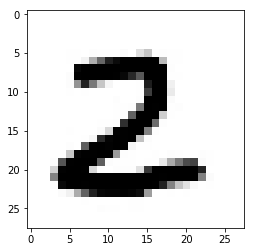

Nearest centroid:  [0]
Time:  10.847235202789307
idx=  48  # Correct:  31 pred:  2  y_test:  2
Nearest centroid:  [0]
Time:  10.613515138626099
idx=  49  # Correct:  32 pred:  2  y_test:  2
Nearest centroid:  [8]
Time:  11.079640865325928
idx=  50  pred:  8  ==WRONG==, actual label:  2


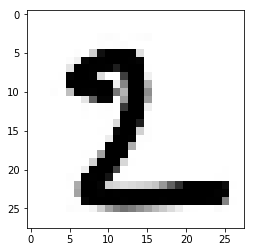

Nearest centroid:  [0]
Time:  11.555041074752808
idx=  51  # Correct:  33 pred:  2  y_test:  2
Nearest centroid:  [2]
Time:  14.172128915786743
idx=  52  # Correct:  34 pred:  2  y_test:  2
Nearest centroid:  [6]
Time:  11.699918031692505
idx=  53  pred:  5  ==WRONG==, actual label:  2


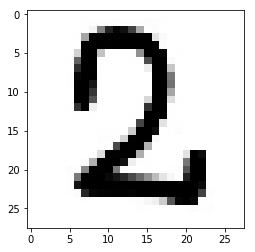

Nearest centroid:  [0]
Time:  9.81016492843628
idx=  54  # Correct:  35 pred:  2  y_test:  2
Nearest centroid:  [8]
Time:  12.503304243087769
idx=  55  # Correct:  36 pred:  2  y_test:  2
Nearest centroid:  [0]
Time:  11.866743087768555
idx=  56  # Correct:  37 pred:  2  y_test:  2
Nearest centroid:  [0]
Time:  10.277787923812866
idx=  57  # Correct:  38 pred:  2  y_test:  2
Nearest centroid:  [0]
Time:  10.215970993041992
idx=  58  # Correct:  39 pred:  2  y_test:  2
Nearest centroid:  [6]
Time:  10.348268985748291
idx=  59  # Correct:  40 pred:  2  y_test:  2
Nearest centroid:  [0]
Time:  10.747586965560913
idx=  60  # Correct:  41 pred:  3  y_test:  3
Nearest centroid:  [6]
Time:  13.211682796478271
idx=  61  # Correct:  42 pred:  3  y_test:  3
Nearest centroid:  [8]
Time:  12.035113096237183
idx=  62  # Correct:  43 pred:  3  y_test:  3
Nearest centroid:  [5]
Time:  10.416424989700317
idx=  63  # Correct:  44 pred:  3  y_test:  3
Nearest centroid:  [1]
Time:  18.9074490070343
idx= 

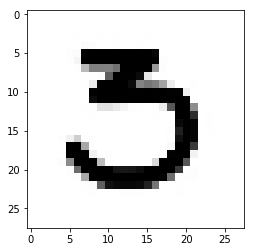

Nearest centroid:  [2]
Time:  16.8487069606781
idx=  76  # Correct:  56 pred:  3  y_test:  3
Nearest centroid:  [6]
Time:  13.62905502319336
idx=  77  # Correct:  57 pred:  3  y_test:  3
Nearest centroid:  [0]
Time:  9.752503871917725
idx=  78  # Correct:  58 pred:  3  y_test:  3
Nearest centroid:  [0]
Time:  14.692818880081177
idx=  79  # Correct:  59 pred:  3  y_test:  3
Nearest centroid:  [5]
Time:  10.16063404083252
idx=  80  pred:  6  ==WRONG==, actual label:  4


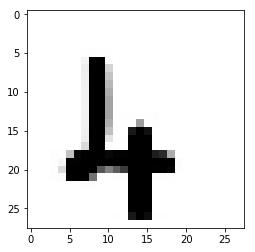

Nearest centroid:  [5]
Time:  9.702202796936035
idx=  81  # Correct:  60 pred:  4  y_test:  4
Nearest centroid:  [0]
Time:  9.639894008636475
idx=  82  pred:  0  ==WRONG==, actual label:  4


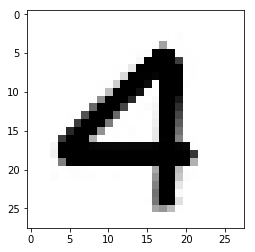

Nearest centroid:  [7]
Time:  9.53882098197937
idx=  83  pred:  0  ==WRONG==, actual label:  4


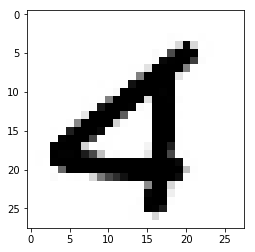

Nearest centroid:  [8]
Time:  10.640432834625244
idx=  84  # Correct:  61 pred:  4  y_test:  4
Nearest centroid:  [8]
Time:  11.801551818847656
idx=  85  pred:  6  ==WRONG==, actual label:  4


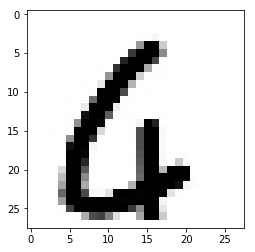

Nearest centroid:  [0]
Time:  10.157050848007202
idx=  86  pred:  0  ==WRONG==, actual label:  4


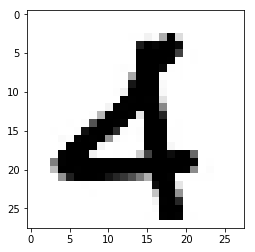

Nearest centroid:  [1]
Time:  15.154523849487305
idx=  87  pred:  6  ==WRONG==, actual label:  4


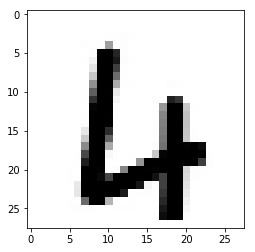

Nearest centroid:  [8]
Time:  13.698271036148071
idx=  88  pred:  6  ==WRONG==, actual label:  4


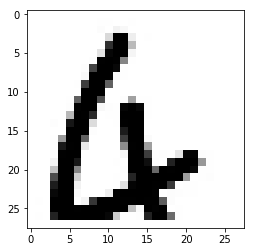

Nearest centroid:  [2]
Time:  19.140910863876343
idx=  89  pred:  9  ==WRONG==, actual label:  4


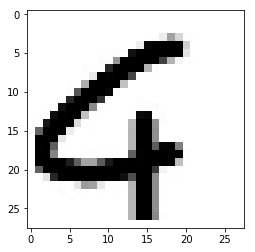

Nearest centroid:  [5]
Time:  11.269986867904663
idx=  90  pred:  6  ==WRONG==, actual label:  4


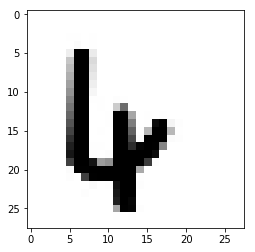

Nearest centroid:  [0]
Time:  12.165196657180786
idx=  91  pred:  6  ==WRONG==, actual label:  4


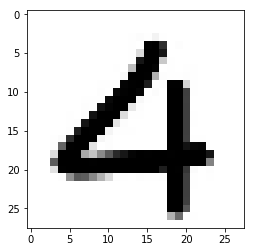

Nearest centroid:  [0]
Time:  12.736227035522461
idx=  92  pred:  6  ==WRONG==, actual label:  4


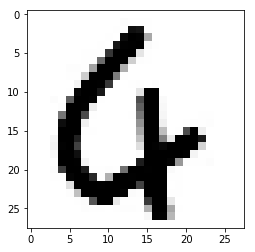

Nearest centroid:  [9]
Time:  12.677001953125
idx=  93  pred:  6  ==WRONG==, actual label:  4


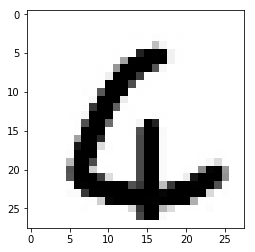

Nearest centroid:  [0]
Time:  10.95951795578003
idx=  94  pred:  6  ==WRONG==, actual label:  4


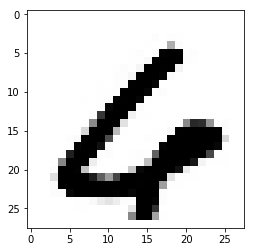

Nearest centroid:  [7]
Time:  9.337950944900513
idx=  95  pred:  6  ==WRONG==, actual label:  4


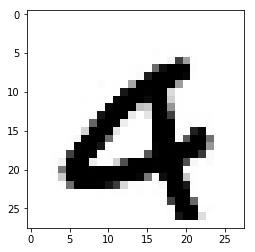

Nearest centroid:  [8]
Time:  12.242960214614868
idx=  96  # Correct:  62 pred:  4  y_test:  4
Nearest centroid:  [9]
Time:  10.826127767562866
idx=  97  pred:  6  ==WRONG==, actual label:  4


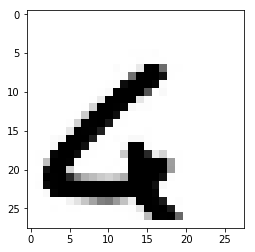

Nearest centroid:  [8]
Time:  10.743407726287842
idx=  98  # Correct:  63 pred:  4  y_test:  4
Nearest centroid:  [0]
Time:  12.302841901779175
idx=  99  pred:  6  ==WRONG==, actual label:  4


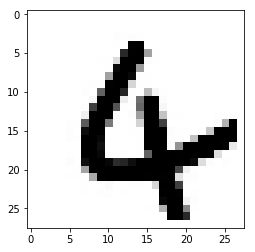

Nearest centroid:  [0]
Time:  10.231163263320923
idx=  100  # Correct:  64 pred:  5  y_test:  5
Nearest centroid:  [0]
Time:  9.748378992080688
idx=  101  # Correct:  65 pred:  5  y_test:  5
Nearest centroid:  [0]
Time:  12.209750890731812
idx=  102  # Correct:  66 pred:  5  y_test:  5
Nearest centroid:  [6]
Time:  10.674736976623535
idx=  103  # Correct:  67 pred:  5  y_test:  5
Nearest centroid:  [3]
Time:  11.069955825805664
idx=  104  # Correct:  68 pred:  5  y_test:  5
Nearest centroid:  [1]
Time:  18.36702799797058
idx=  105  # Correct:  69 pred:  5  y_test:  5
Nearest centroid:  [0]
Time:  10.976624011993408
idx=  106  # Correct:  70 pred:  5  y_test:  5
Nearest centroid:  [0]
Time:  12.972970008850098
idx=  107  # Correct:  71 pred:  5  y_test:  5
Nearest centroid:  [6]
Time:  12.145904064178467
idx=  108  # Correct:  72 pred:  5  y_test:  5
Nearest centroid:  [6]
Time:  12.598294019699097
idx=  109  # Correct:  73 pred:  5  y_test:  5
Nearest centroid:  [1]
Time:  16.699213743

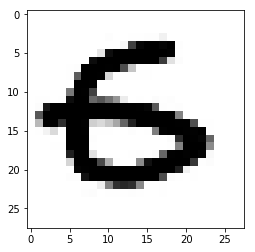

Nearest centroid:  [1]
Time:  13.531666994094849
idx=  126  pred:  5  ==WRONG==, actual label:  6


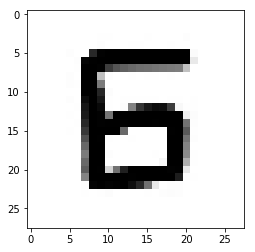

Nearest centroid:  [0]
Time:  9.793417930603027
idx=  127  # Correct:  89 pred:  6  y_test:  6
Nearest centroid:  [7]
Time:  10.402848958969116
idx=  128  # Correct:  90 pred:  6  y_test:  6
Nearest centroid:  [3]
Time:  11.693306922912598
idx=  129  pred:  5  ==WRONG==, actual label:  6


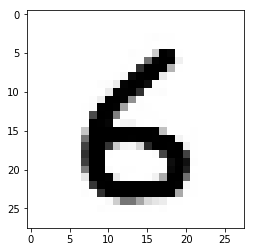

Nearest centroid:  [6]
Time:  10.371846914291382
idx=  130  # Correct:  91 pred:  6  y_test:  6
Nearest centroid:  [6]
Time:  10.86745285987854
idx=  131  pred:  5  ==WRONG==, actual label:  6


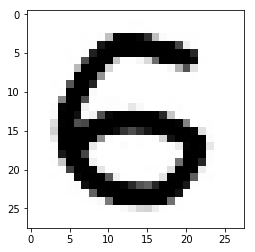

Nearest centroid:  [6]
Time:  10.190262079238892
idx=  132  # Correct:  92 pred:  6  y_test:  6
Nearest centroid:  [5]
Time:  9.23418116569519
idx=  133  pred:  0  ==WRONG==, actual label:  6


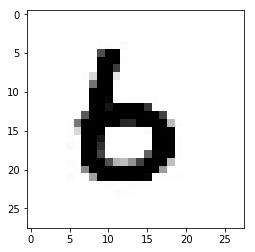

Nearest centroid:  [0]
Time:  9.688771963119507
idx=  134  # Correct:  93 pred:  6  y_test:  6
Nearest centroid:  [9]
Time:  9.768828868865967
idx=  135  # Correct:  94 pred:  6  y_test:  6
Nearest centroid:  [6]
Time:  10.241729021072388
idx=  136  # Correct:  95 pred:  6  y_test:  6
Nearest centroid:  [0]
Time:  9.148967266082764
idx=  137  # Correct:  96 pred:  6  y_test:  6
Nearest centroid:  [6]
Time:  9.989034175872803
idx=  138  # Correct:  97 pred:  6  y_test:  6
Nearest centroid:  [8]
Time:  10.537022113800049
idx=  139  pred:  8  ==WRONG==, actual label:  6


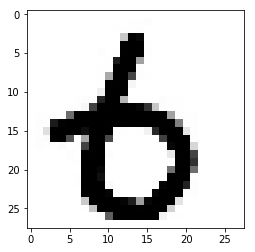

Nearest centroid:  [5]
Time:  10.631494998931885
idx=  140  # Correct:  98 pred:  7  y_test:  7
Nearest centroid:  [2]
Time:  13.046262979507446
idx=  141  # Correct:  99 pred:  7  y_test:  7
Nearest centroid:  [2]
Time:  13.970119953155518
idx=  142  # Correct:  100 pred:  7  y_test:  7
Nearest centroid:  [5]
Time:  10.354758024215698
idx=  143  # Correct:  101 pred:  7  y_test:  7
Nearest centroid:  [5]
Time:  12.477006196975708
idx=  144  pred:  5  ==WRONG==, actual label:  7


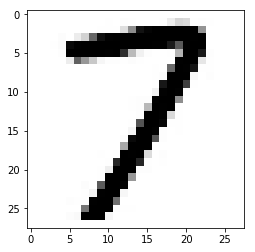

Nearest centroid:  [2]
Time:  14.639407873153687
idx=  145  # Correct:  102 pred:  7  y_test:  7
Nearest centroid:  [8]
Time:  13.118179082870483
idx=  146  pred:  3  ==WRONG==, actual label:  7


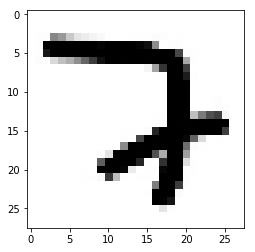

Nearest centroid:  [8]
Time:  11.627542972564697
idx=  147  pred:  9  ==WRONG==, actual label:  7


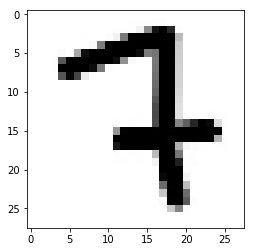

Nearest centroid:  [8]
Time:  10.612344980239868
idx=  148  pred:  3  ==WRONG==, actual label:  7


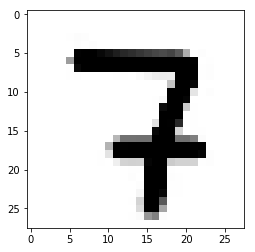

Nearest centroid:  [2]
Time:  16.376731157302856
idx=  149  # Correct:  103 pred:  7  y_test:  7
Nearest centroid:  [2]
Time:  15.743030786514282
idx=  150  # Correct:  104 pred:  7  y_test:  7
Nearest centroid:  [0]
Time:  13.118239879608154
idx=  151  pred:  9  ==WRONG==, actual label:  7


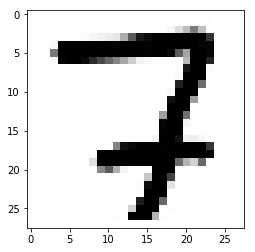

Nearest centroid:  [2]
Time:  13.01125979423523
idx=  152  # Correct:  105 pred:  7  y_test:  7
Nearest centroid:  [8]
Time:  10.020730257034302
idx=  153  pred:  9  ==WRONG==, actual label:  7


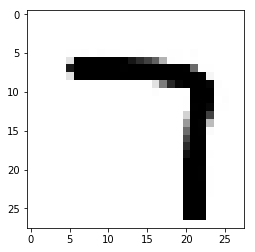

Nearest centroid:  [2]
Time:  15.132706880569458
idx=  154  pred:  3  ==WRONG==, actual label:  7


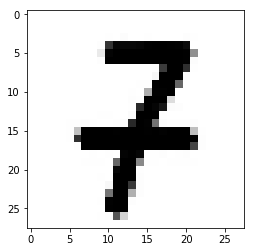

Nearest centroid:  [2]
Time:  14.439234972000122
idx=  155  pred:  2  ==WRONG==, actual label:  7


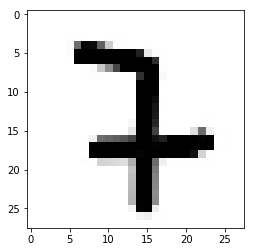

Nearest centroid:  [8]
Time:  10.165466070175171
idx=  156  pred:  9  ==WRONG==, actual label:  7


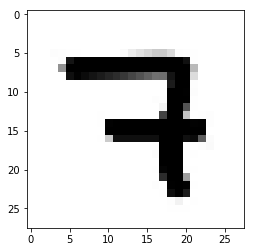

Nearest centroid:  [8]
Time:  9.232876062393188
idx=  157  pred:  3  ==WRONG==, actual label:  7


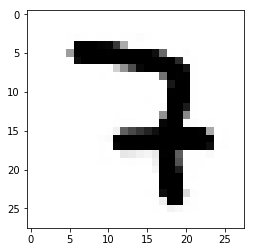

Nearest centroid:  [2]
Time:  11.990458965301514
idx=  158  # Correct:  106 pred:  7  y_test:  7
Nearest centroid:  [2]
Time:  11.462206363677979
idx=  159  # Correct:  107 pred:  7  y_test:  7
Nearest centroid:  [8]
Time:  8.94679880142212
idx=  160  # Correct:  108 pred:  8  y_test:  8
Nearest centroid:  [0]
Time:  8.468043088912964
idx=  161  # Correct:  109 pred:  8  y_test:  8
Nearest centroid:  [1]
Time:  11.368783712387085
idx=  162  # Correct:  110 pred:  8  y_test:  8
Nearest centroid:  [8]
Time:  9.405004739761353
idx=  163  pred:  6  ==WRONG==, actual label:  8


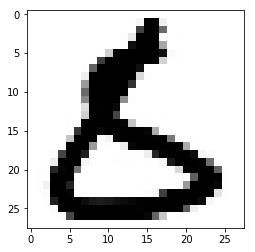

Nearest centroid:  [2]
Time:  10.410715103149414
idx=  164  # Correct:  111 pred:  8  y_test:  8
Nearest centroid:  [6]
Time:  8.334366798400879
idx=  165  # Correct:  112 pred:  8  y_test:  8
Nearest centroid:  [2]
Time:  10.99367904663086
idx=  166  # Correct:  113 pred:  8  y_test:  8
Nearest centroid:  [0]
Time:  8.17628288269043
idx=  167  # Correct:  114 pred:  8  y_test:  8
Nearest centroid:  [6]
Time:  8.743075847625732
idx=  168  # Correct:  115 pred:  8  y_test:  8
Nearest centroid:  [6]
Time:  9.052327871322632
idx=  169  pred:  0  ==WRONG==, actual label:  8


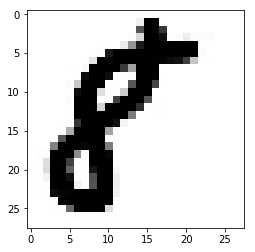

Nearest centroid:  [8]
Time:  8.499599933624268
idx=  170  # Correct:  116 pred:  8  y_test:  8
Nearest centroid:  [2]
Time:  13.750967025756836
idx=  171  pred:  5  ==WRONG==, actual label:  8


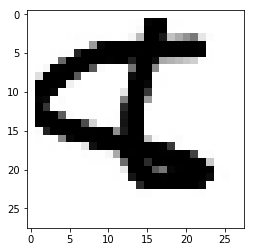

Nearest centroid:  [0]
Time:  8.05298113822937
idx=  172  # Correct:  117 pred:  8  y_test:  8
Nearest centroid:  [6]
Time:  8.54903793334961
idx=  173  # Correct:  118 pred:  8  y_test:  8
Nearest centroid:  [8]
Time:  8.678733825683594
idx=  174  # Correct:  119 pred:  8  y_test:  8
Nearest centroid:  [8]
Time:  8.745481014251709
idx=  175  # Correct:  120 pred:  8  y_test:  8
Nearest centroid:  [9]
Time:  9.515692234039307
idx=  176  # Correct:  121 pred:  8  y_test:  8
Nearest centroid:  [2]
Time:  10.524878978729248
idx=  177  # Correct:  122 pred:  8  y_test:  8
Nearest centroid:  [8]
Time:  9.530326128005981
idx=  178  pred:  6  ==WRONG==, actual label:  8


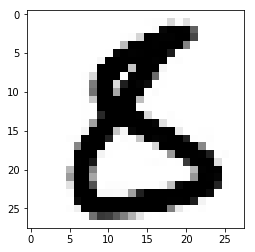

Nearest centroid:  [2]
Time:  10.36841893196106
idx=  179  # Correct:  123 pred:  8  y_test:  8
Nearest centroid:  [5]
Time:  8.646082162857056
idx=  180  pred:  2  ==WRONG==, actual label:  9


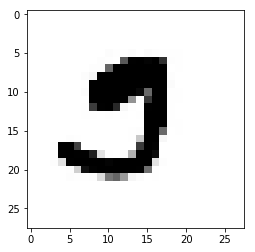

Nearest centroid:  [6]
Time:  9.084818840026855
idx=  181  # Correct:  124 pred:  9  y_test:  9
Nearest centroid:  [5]
Time:  9.593139886856079
idx=  182  pred:  5  ==WRONG==, actual label:  9


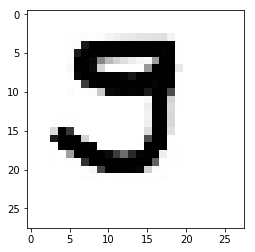

Nearest centroid:  [0]
Time:  8.181672096252441
idx=  183  pred:  5  ==WRONG==, actual label:  9


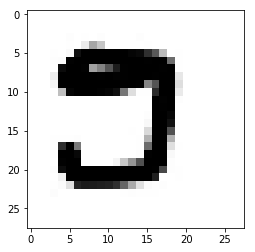

Nearest centroid:  [8]
Time:  7.90340518951416
idx=  184  # Correct:  125 pred:  9  y_test:  9
Nearest centroid:  [8]
Time:  9.492935180664062
idx=  185  # Correct:  126 pred:  9  y_test:  9
Nearest centroid:  [6]
Time:  9.244156837463379
idx=  186  pred:  5  ==WRONG==, actual label:  9


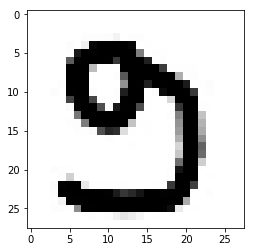

Nearest centroid:  [2]
Time:  11.392402172088623
idx=  187  # Correct:  127 pred:  9  y_test:  9
Nearest centroid:  [6]
Time:  8.883961915969849
idx=  188  pred:  5  ==WRONG==, actual label:  9


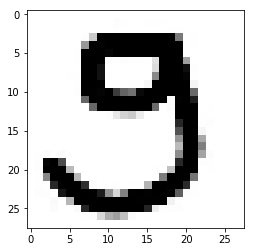

Nearest centroid:  [6]
Time:  8.36345911026001
idx=  189  pred:  8  ==WRONG==, actual label:  9


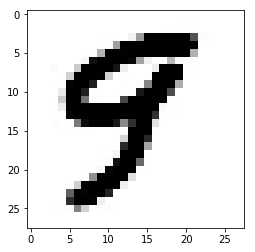

Nearest centroid:  [8]
Time:  9.00863790512085
idx=  190  # Correct:  128 pred:  9  y_test:  9
Nearest centroid:  [6]
Time:  8.432364702224731
idx=  191  pred:  5  ==WRONG==, actual label:  9


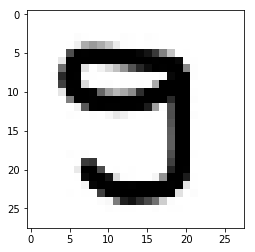

Nearest centroid:  [5]
Time:  9.989452838897705
idx=  192  pred:  5  ==WRONG==, actual label:  9


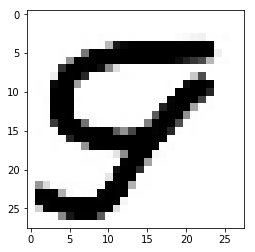

Nearest centroid:  [2]
Time:  10.50150990486145
idx=  193  # Correct:  129 pred:  9  y_test:  9
Nearest centroid:  [0]
Time:  9.535376071929932
idx=  194  pred:  5  ==WRONG==, actual label:  9


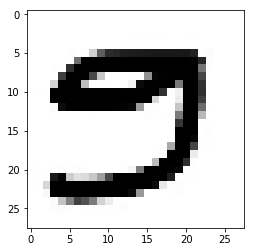

Nearest centroid:  [8]
Time:  8.262434005737305
idx=  195  # Correct:  130 pred:  9  y_test:  9
Nearest centroid:  [6]
Time:  8.601511001586914
idx=  196  pred:  5  ==WRONG==, actual label:  9


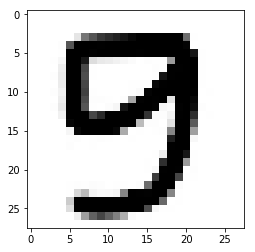

Nearest centroid:  [8]
Time:  8.28242015838623
idx=  197  # Correct:  131 pred:  9  y_test:  9
Nearest centroid:  [2]
Time:  11.5916428565979
idx=  198  # Correct:  132 pred:  9  y_test:  9
Nearest centroid:  [8]
Time:  8.336668014526367
idx=  199  # Correct:  133 pred:  9  y_test:  9


In [922]:
correct = 0
for idx, image in enumerate(test_stack_reshape):
    pred, _ = kmeans_knn(test_stack_reshape[idx], c, l, freeman_X_resampled, y_resampled, 10, 5)
    if test_lbl[idx] == pred:
        correct +=1
        print("idx= ",idx," # Correct: ",correct,"pred: ",pred," y_test: ", test_lbl[idx])
    else:
        print("idx= ",idx," pred: ",pred," ==WRONG==, actual label: ",test_lbl[idx])
        plt.imshow(image.reshape((28,28)), cmap=cm.binary)
        plt.show()

After running, we got 133/200 correct predictions which accounted for 66.5%

#### Prediction on test set with noise tolerance freeman code:

Due to the problem that some images contain noise inside such as a dot in the image, we have developed a new freeman code generator to cope with this. The length of output freeman code is shorter than our original version. But after testing, the accuracy of this new freeman code on test set is not as high as in the original freeman code. So I don't use it for predicting.

Nearest centroid:  [1]
Time:  3.1618010997772217
idx=  0  # Correct:  1 pred:  0  y_test:  0
Nearest centroid:  [5]
Time:  2.6225709915161133
idx=  1  # Correct:  2 pred:  0  y_test:  0
Nearest centroid:  [1]
Time:  2.7652080059051514
idx=  2  # Correct:  3 pred:  0  y_test:  0
Nearest centroid:  [5]
Time:  2.3313000202178955
idx=  3  # Correct:  4 pred:  0  y_test:  0
Nearest centroid:  [1]
Time:  2.406916856765747
idx=  4  # Correct:  5 pred:  0  y_test:  0
Nearest centroid:  [1]
Time:  2.628216028213501
idx=  5  # Correct:  6 pred:  0  y_test:  0
Nearest centroid:  [1]
Time:  4.017388105392456
idx=  6  pred:  6  ==WRONG==, actual label:  0


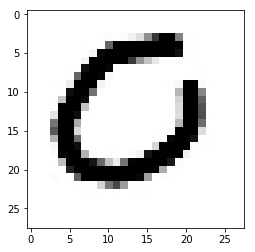

Nearest centroid:  [1]
Time:  2.8879621028900146
idx=  7  # Correct:  7 pred:  0  y_test:  0
Nearest centroid:  [1]
Time:  3.3164801597595215
idx=  8  # Correct:  8 pred:  0  y_test:  0
Nearest centroid:  [2]
Time:  5.5679261684417725
idx=  9  # Correct:  9 pred:  0  y_test:  0
Nearest centroid:  [1]
Time:  3.1654069423675537
idx=  10  # Correct:  10 pred:  0  y_test:  0
Nearest centroid:  [2]
Time:  5.041683197021484
idx=  11  pred:  8  ==WRONG==, actual label:  0


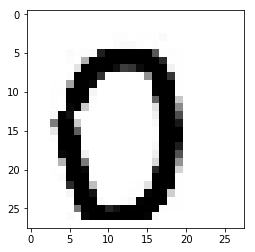

Nearest centroid:  [2]
Time:  4.674569129943848
idx=  12  # Correct:  11 pred:  0  y_test:  0
Nearest centroid:  [1]
Time:  2.3839590549468994
idx=  13  # Correct:  12 pred:  0  y_test:  0
Nearest centroid:  [1]
Time:  2.795253038406372
idx=  14  # Correct:  13 pred:  0  y_test:  0
Nearest centroid:  [1]
Time:  2.72621488571167
idx=  15  # Correct:  14 pred:  0  y_test:  0
Nearest centroid:  [1]
Time:  4.486283779144287
idx=  16  pred:  3  ==WRONG==, actual label:  0


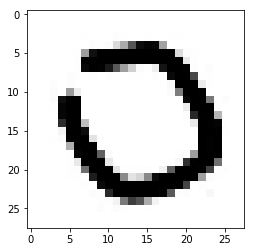

Nearest centroid:  [2]
Time:  6.655117034912109
idx=  17  pred:  8  ==WRONG==, actual label:  0


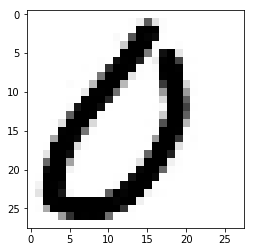

Nearest centroid:  [5]
Time:  3.0890750885009766
idx=  18  # Correct:  15 pred:  0  y_test:  0
Nearest centroid:  [1]
Time:  3.4867987632751465
idx=  19  # Correct:  16 pred:  0  y_test:  0
Nearest centroid:  [8]
Time:  6.147925853729248
idx=  20  # Correct:  17 pred:  1  y_test:  1
Nearest centroid:  [8]
Time:  4.714182138442993
idx=  21  # Correct:  18 pred:  1  y_test:  1
Nearest centroid:  [8]
Time:  4.287685871124268
idx=  22  # Correct:  19 pred:  1  y_test:  1
Nearest centroid:  [0]
Time:  5.899370908737183
idx=  23  pred:  7  ==WRONG==, actual label:  1


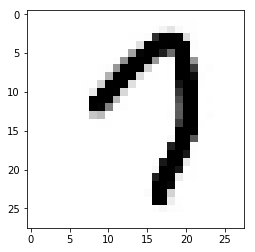

Nearest centroid:  [9]
Time:  4.472198247909546
idx=  24  pred:  8  ==WRONG==, actual label:  1


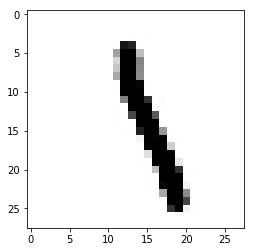

Nearest centroid:  [8]
Time:  4.017809152603149
idx=  25  # Correct:  20 pred:  1  y_test:  1
Nearest centroid:  [0]
Time:  6.374446153640747
idx=  26  # Correct:  21 pred:  1  y_test:  1
Nearest centroid:  [0]
Time:  5.22263503074646
idx=  27  # Correct:  22 pred:  1  y_test:  1
Nearest centroid:  [9]
Time:  4.525739908218384
idx=  28  pred:  9  ==WRONG==, actual label:  1


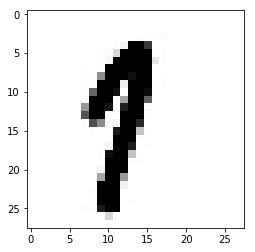

Nearest centroid:  [8]
Time:  4.546644926071167
idx=  29  # Correct:  23 pred:  1  y_test:  1
Nearest centroid:  [8]
Time:  3.922295093536377
idx=  30  # Correct:  24 pred:  1  y_test:  1
Nearest centroid:  [8]
Time:  4.641986131668091
idx=  31  pred:  7  ==WRONG==, actual label:  1


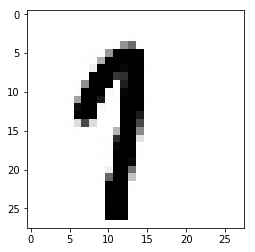

Nearest centroid:  [8]
Time:  4.134233236312866
idx=  32  # Correct:  25 pred:  1  y_test:  1
Nearest centroid:  [8]
Time:  6.167452096939087
idx=  33  pred:  7  ==WRONG==, actual label:  1


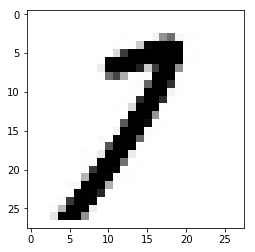

Nearest centroid:  [8]
Time:  5.051197052001953
idx=  34  # Correct:  26 pred:  1  y_test:  1
Nearest centroid:  [8]
Time:  4.6792120933532715
idx=  35  # Correct:  27 pred:  1  y_test:  1
Nearest centroid:  [0]
Time:  6.195091009140015
idx=  36  # Correct:  28 pred:  1  y_test:  1
Nearest centroid:  [0]
Time:  6.5596208572387695
idx=  37  pred:  9  ==WRONG==, actual label:  1


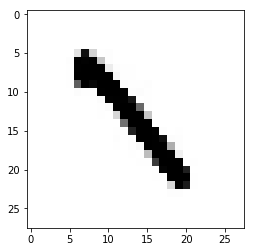

Nearest centroid:  [8]
Time:  4.2376549243927
idx=  38  pred:  9  ==WRONG==, actual label:  1


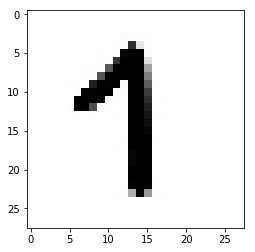

Nearest centroid:  [6]
Time:  4.237490892410278
idx=  39  pred:  8  ==WRONG==, actual label:  1


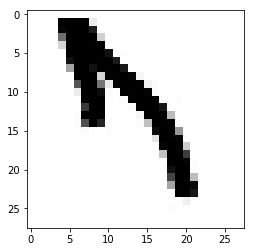

Nearest centroid:  [8]
Time:  5.1104958057403564
idx=  40  # Correct:  29 pred:  2  y_test:  2
Nearest centroid:  [4]
Time:  2.964053153991699
idx=  41  pred:  3  ==WRONG==, actual label:  2


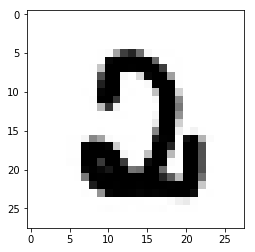

Nearest centroid:  [2]
Time:  5.028116941452026
idx=  42  # Correct:  30 pred:  2  y_test:  2
Nearest centroid:  [9]
Time:  8.640498876571655
idx=  43  # Correct:  31 pred:  2  y_test:  2
Nearest centroid:  [3]
Time:  4.509405136108398
idx=  44  # Correct:  32 pred:  2  y_test:  2
Nearest centroid:  [9]
Time:  6.529001951217651
idx=  45  # Correct:  33 pred:  2  y_test:  2
Nearest centroid:  [6]
Time:  5.379093170166016
idx=  46  pred:  3  ==WRONG==, actual label:  2


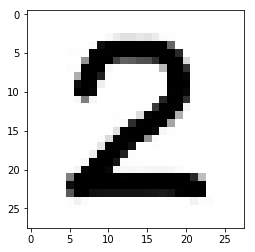

Nearest centroid:  [6]
Time:  6.472055673599243
idx=  47  pred:  8  ==WRONG==, actual label:  2


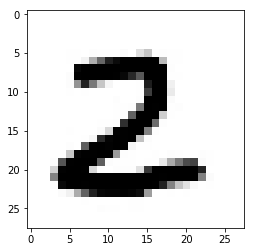

Nearest centroid:  [7]
Time:  8.458476781845093
idx=  48  # Correct:  34 pred:  2  y_test:  2
Nearest centroid:  [1]
Time:  4.381699800491333
idx=  49  pred:  8  ==WRONG==, actual label:  2


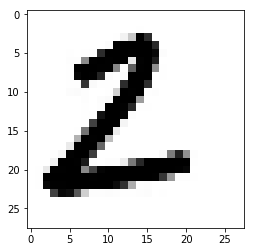

Nearest centroid:  [6]
Time:  5.646136045455933
idx=  50  pred:  8  ==WRONG==, actual label:  2


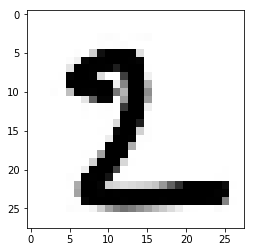

Nearest centroid:  [3]
Time:  5.357000112533569
idx=  51  # Correct:  35 pred:  2  y_test:  2
Nearest centroid:  [9]
Time:  6.863302946090698
idx=  52  # Correct:  36 pred:  2  y_test:  2
Nearest centroid:  [6]
Time:  7.681362152099609
idx=  53  pred:  3  ==WRONG==, actual label:  2


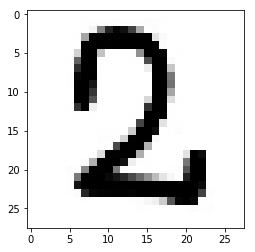

Nearest centroid:  [8]
Time:  6.189826965332031
idx=  54  # Correct:  37 pred:  2  y_test:  2
Nearest centroid:  [5]
Time:  3.9901461601257324
idx=  55  pred:  1  ==WRONG==, actual label:  2


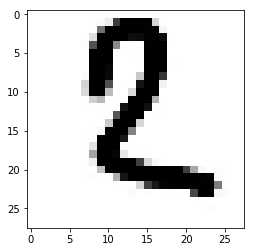

Nearest centroid:  [3]
Time:  5.217051982879639
idx=  56  # Correct:  38 pred:  2  y_test:  2
Nearest centroid:  [3]
Time:  3.9710447788238525
idx=  57  # Correct:  39 pred:  2  y_test:  2
Nearest centroid:  [2]
Time:  4.929510116577148
idx=  58  pred:  8  ==WRONG==, actual label:  2


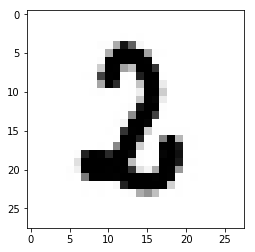

Nearest centroid:  [2]
Time:  6.6126930713653564
idx=  59  # Correct:  40 pred:  2  y_test:  2
Nearest centroid:  [2]
Time:  5.261819839477539
idx=  60  # Correct:  41 pred:  3  y_test:  3
Nearest centroid:  [1]
Time:  4.158583641052246
idx=  61  # Correct:  42 pred:  3  y_test:  3
Nearest centroid:  [6]
Time:  4.880980968475342
idx=  62  # Correct:  43 pred:  3  y_test:  3
Nearest centroid:  [8]
Time:  4.700200080871582
idx=  63  # Correct:  44 pred:  3  y_test:  3
Nearest centroid:  [2]
Time:  7.348268032073975
idx=  64  # Correct:  45 pred:  3  y_test:  3
Nearest centroid:  [6]
Time:  6.950299263000488
idx=  65  # Correct:  46 pred:  3  y_test:  3
Nearest centroid:  [1]
Time:  3.756361961364746
idx=  66  # Correct:  47 pred:  3  y_test:  3
Nearest centroid:  [2]
Time:  5.334370136260986
idx=  67  # Correct:  48 pred:  3  y_test:  3
Nearest centroid:  [9]
Time:  10.120936155319214
idx=  68  # Correct:  49 pred:  3  y_test:  3
Nearest centroid:  [8]
Time:  5.7862708568573
idx=  69  # 

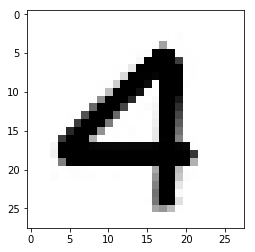

Nearest centroid:  [3]
Time:  3.705717086791992
idx=  83  pred:  0  ==WRONG==, actual label:  4


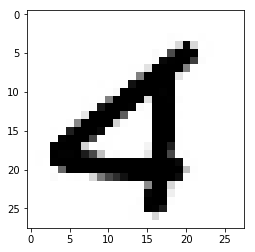

Nearest centroid:  [0]
Time:  6.562849044799805
idx=  84  # Correct:  63 pred:  4  y_test:  4
Nearest centroid:  [9]
Time:  6.169547080993652
idx=  85  pred:  8  ==WRONG==, actual label:  4


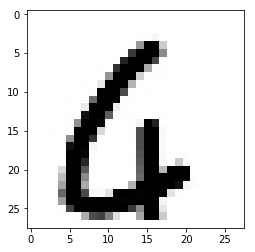

Nearest centroid:  [3]
Time:  3.366421699523926
idx=  86  pred:  0  ==WRONG==, actual label:  4


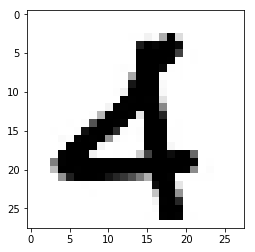

Nearest centroid:  [1]
Time:  4.696130037307739
idx=  87  pred:  6  ==WRONG==, actual label:  4


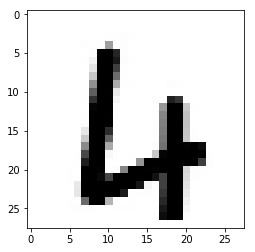

Nearest centroid:  [1]
Time:  5.217844009399414
idx=  88  # Correct:  64 pred:  4  y_test:  4
Nearest centroid:  [9]
Time:  9.346014261245728
idx=  89  pred:  9  ==WRONG==, actual label:  4


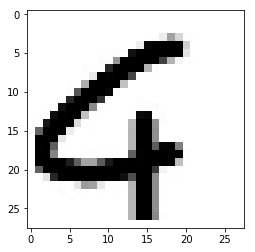

Nearest centroid:  [0]
Time:  6.198035955429077
idx=  90  # Correct:  65 pred:  4  y_test:  4
Nearest centroid:  [3]
Time:  4.357133150100708
idx=  91  pred:  6  ==WRONG==, actual label:  4


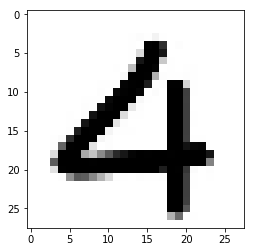

Nearest centroid:  [2]
Time:  6.957977056503296
idx=  92  pred:  8  ==WRONG==, actual label:  4


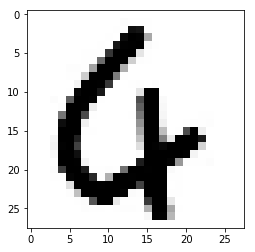

Nearest centroid:  [7]
Time:  6.039772987365723
idx=  93  pred:  8  ==WRONG==, actual label:  4


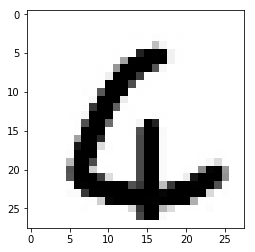

Nearest centroid:  [2]
Time:  5.767174005508423
idx=  94  pred:  8  ==WRONG==, actual label:  4


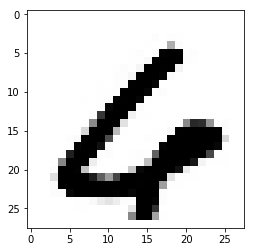

Nearest centroid:  [3]
Time:  3.4068918228149414
idx=  95  # Correct:  66 pred:  4  y_test:  4
Nearest centroid:  [1]
Time:  3.860487937927246
idx=  96  # Correct:  67 pred:  4  y_test:  4
Nearest centroid:  [8]
Time:  6.2626118659973145
idx=  97  pred:  6  ==WRONG==, actual label:  4


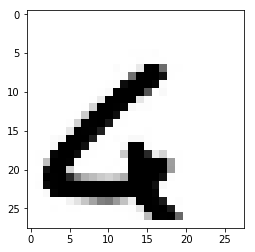

Nearest centroid:  [0]
Time:  5.972445964813232
idx=  98  # Correct:  68 pred:  4  y_test:  4
Nearest centroid:  [5]
Time:  3.7095937728881836
idx=  99  pred:  6  ==WRONG==, actual label:  4


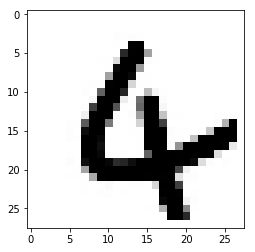

Nearest centroid:  [5]
Time:  3.3648157119750977
idx=  100  pred:  6  ==WRONG==, actual label:  5


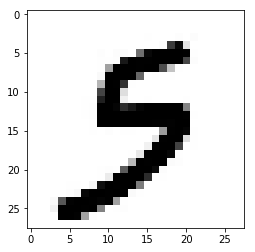

Nearest centroid:  [9]
Time:  6.190758943557739
idx=  101  pred:  3  ==WRONG==, actual label:  5


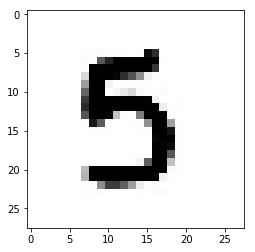

Nearest centroid:  [1]
Time:  4.698109865188599
idx=  102  pred:  3  ==WRONG==, actual label:  5


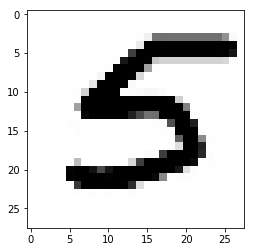

Nearest centroid:  [1]
Time:  4.0287511348724365
idx=  103  pred:  3  ==WRONG==, actual label:  5


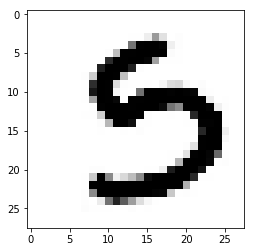

Nearest centroid:  [4]
Time:  3.908170223236084
idx=  104  pred:  3  ==WRONG==, actual label:  5


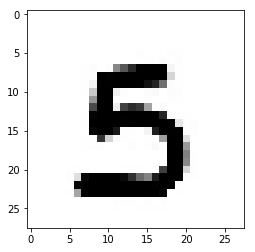

Nearest centroid:  [6]
Time:  6.456536054611206
idx=  105  pred:  3  ==WRONG==, actual label:  5


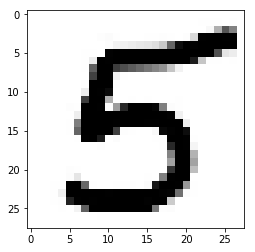

Nearest centroid:  [2]
Time:  6.1520678997039795
idx=  106  pred:  3  ==WRONG==, actual label:  5


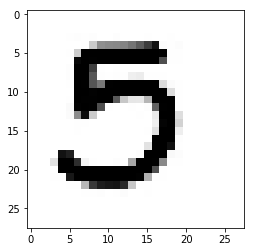

Nearest centroid:  [5]
Time:  4.54065728187561
idx=  107  # Correct:  69 pred:  5  y_test:  5
Nearest centroid:  [1]
Time:  3.75602388381958
idx=  108  pred:  3  ==WRONG==, actual label:  5


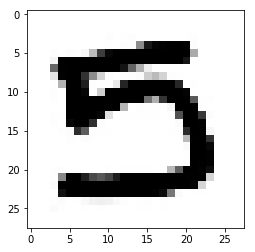

Nearest centroid:  [4]
Time:  4.378596067428589
idx=  109  pred:  3  ==WRONG==, actual label:  5


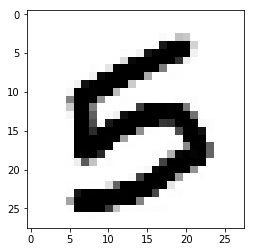

Nearest centroid:  [5]
Time:  5.1818108558654785
idx=  110  pred:  8  ==WRONG==, actual label:  5


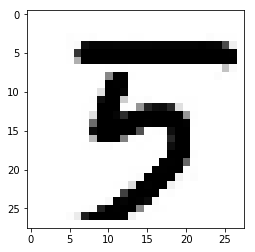

Nearest centroid:  [2]
Time:  7.748760938644409
idx=  111  pred:  3  ==WRONG==, actual label:  5


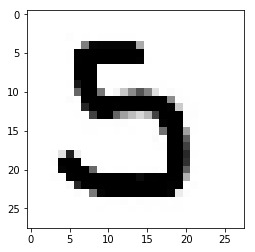

Nearest centroid:  [2]
Time:  7.792311906814575
idx=  112  pred:  3  ==WRONG==, actual label:  5


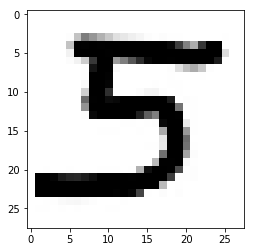

Nearest centroid:  [2]
Time:  7.298813819885254
idx=  113  pred:  8  ==WRONG==, actual label:  5


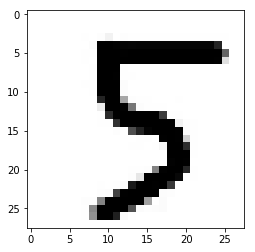

Nearest centroid:  [0]
Time:  6.862992286682129
idx=  114  # Correct:  70 pred:  5  y_test:  5
Nearest centroid:  [7]
Time:  5.240847826004028
idx=  115  pred:  8  ==WRONG==, actual label:  5


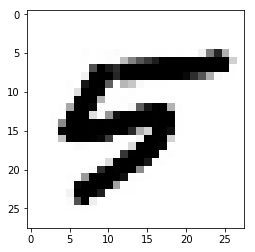

Nearest centroid:  [1]
Time:  3.3516159057617188
idx=  116  pred:  3  ==WRONG==, actual label:  5


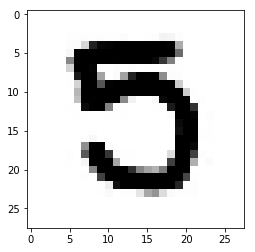

Nearest centroid:  [1]
Time:  4.665853023529053
idx=  117  pred:  2  ==WRONG==, actual label:  5


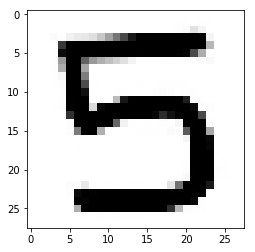

Nearest centroid:  [0]
Time:  6.412621021270752
idx=  118  pred:  9  ==WRONG==, actual label:  5


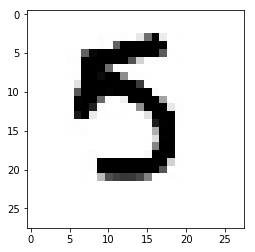

Nearest centroid:  [9]
Time:  5.947508096694946
idx=  119  pred:  9  ==WRONG==, actual label:  5


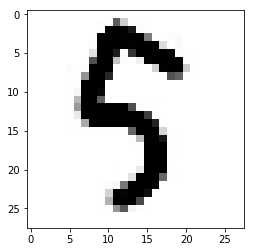

Nearest centroid:  [5]
Time:  2.7703640460968018
idx=  120  # Correct:  71 pred:  6  y_test:  6
Nearest centroid:  [1]
Time:  2.7566211223602295
idx=  121  # Correct:  72 pred:  6  y_test:  6
Nearest centroid:  [4]
Time:  2.84136700630188
idx=  122  pred:  8  ==WRONG==, actual label:  6


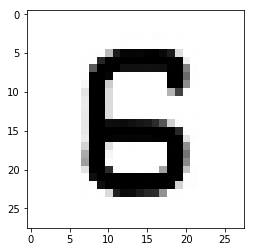

Nearest centroid:  [1]
Time:  3.0668652057647705
idx=  123  # Correct:  73 pred:  6  y_test:  6
Nearest centroid:  [1]
Time:  3.646437168121338
idx=  124  # Correct:  74 pred:  6  y_test:  6
Nearest centroid:  [1]
Time:  3.1188910007476807
idx=  125  # Correct:  75 pred:  6  y_test:  6
Nearest centroid:  [4]
Time:  2.974213123321533
idx=  126  pred:  8  ==WRONG==, actual label:  6


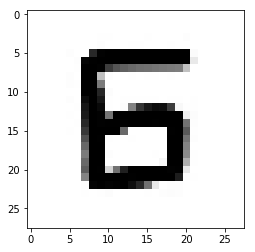

Nearest centroid:  [5]
Time:  2.7843780517578125
idx=  127  # Correct:  76 pred:  6  y_test:  6
Nearest centroid:  [0]
Time:  6.941688060760498
idx=  128  # Correct:  77 pred:  6  y_test:  6
Nearest centroid:  [5]
Time:  3.637173891067505
idx=  129  # Correct:  78 pred:  6  y_test:  6
Nearest centroid:  [1]
Time:  4.434852838516235
idx=  130  # Correct:  79 pred:  6  y_test:  6
Nearest centroid:  [6]
Time:  6.648245096206665
idx=  131  # Correct:  80 pred:  6  y_test:  6
Nearest centroid:  [6]
Time:  4.555298089981079
idx=  132  pred:  8  ==WRONG==, actual label:  6


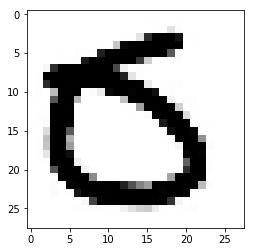

Nearest centroid:  [0]
Time:  5.479449987411499
idx=  133  pred:  0  ==WRONG==, actual label:  6


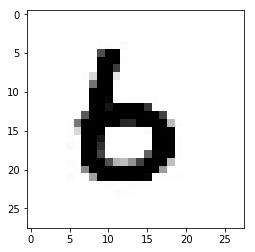

Nearest centroid:  [5]
Time:  2.8158888816833496
idx=  134  # Correct:  81 pred:  6  y_test:  6
Nearest centroid:  [7]
Time:  3.694704055786133
idx=  135  pred:  8  ==WRONG==, actual label:  6


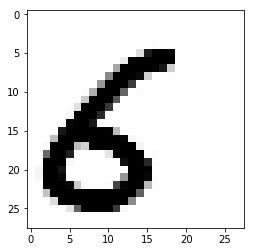

Nearest centroid:  [1]
Time:  3.1926798820495605
idx=  136  # Correct:  82 pred:  6  y_test:  6
Nearest centroid:  [5]
Time:  2.5335018634796143
idx=  137  # Correct:  83 pred:  6  y_test:  6
Nearest centroid:  [1]
Time:  2.7776029109954834
idx=  138  pred:  0  ==WRONG==, actual label:  6


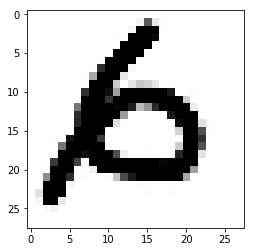

Nearest centroid:  [6]
Time:  4.402982950210571
idx=  139  pred:  8  ==WRONG==, actual label:  6


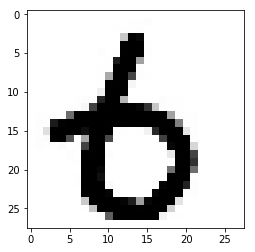

Nearest centroid:  [2]
Time:  4.829911708831787
idx=  140  pred:  3  ==WRONG==, actual label:  7


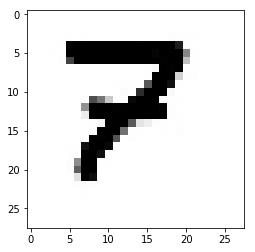

Nearest centroid:  [8]
Time:  6.200897216796875
idx=  141  # Correct:  84 pred:  7  y_test:  7
Nearest centroid:  [8]
Time:  5.993180274963379
idx=  142  # Correct:  85 pred:  7  y_test:  7
Nearest centroid:  [8]
Time:  6.484161853790283
idx=  143  # Correct:  86 pred:  7  y_test:  7
Nearest centroid:  [8]
Time:  8.584804058074951
idx=  144  # Correct:  87 pred:  7  y_test:  7
Nearest centroid:  [0]
Time:  7.077189207077026
idx=  145  # Correct:  88 pred:  7  y_test:  7
Nearest centroid:  [0]
Time:  8.157815933227539
idx=  146  # Correct:  89 pred:  7  y_test:  7
Nearest centroid:  [0]
Time:  7.799922227859497
idx=  147  # Correct:  90 pred:  7  y_test:  7
Nearest centroid:  [9]
Time:  6.8176350593566895
idx=  148  pred:  3  ==WRONG==, actual label:  7


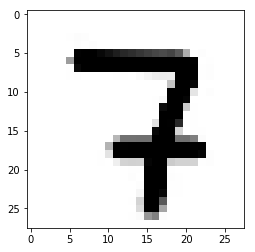

Nearest centroid:  [8]
Time:  7.0735390186309814
idx=  149  # Correct:  91 pred:  7  y_test:  7
Nearest centroid:  [8]
Time:  6.3840789794921875
idx=  150  # Correct:  92 pred:  7  y_test:  7
Nearest centroid:  [0]
Time:  9.246638059616089
idx=  151  # Correct:  93 pred:  7  y_test:  7
Nearest centroid:  [5]
Time:  3.192362070083618
idx=  152  pred:  0  ==WRONG==, actual label:  7


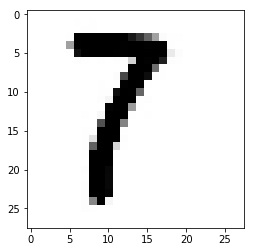

Nearest centroid:  [1]
Time:  3.3589258193969727
idx=  153  pred:  0  ==WRONG==, actual label:  7


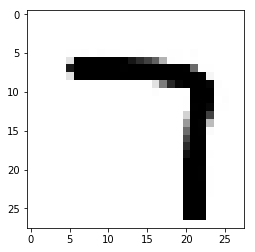

Nearest centroid:  [8]
Time:  6.418869972229004
idx=  154  # Correct:  94 pred:  7  y_test:  7
Nearest centroid:  [8]
Time:  6.956281661987305
idx=  155  pred:  2  ==WRONG==, actual label:  7


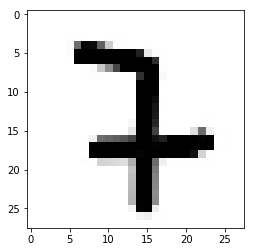

Nearest centroid:  [6]
Time:  6.273952960968018
idx=  156  pred:  9  ==WRONG==, actual label:  7


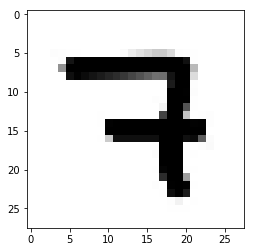

Nearest centroid:  [0]
Time:  6.891696929931641
idx=  157  # Correct:  95 pred:  7  y_test:  7
Nearest centroid:  [2]
Time:  5.083597898483276
idx=  158  pred:  8  ==WRONG==, actual label:  7


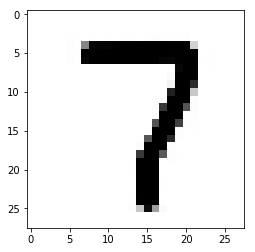

Nearest centroid:  [8]
Time:  7.055937051773071
idx=  159  # Correct:  96 pred:  7  y_test:  7
Nearest centroid:  [4]
Time:  3.196859836578369
idx=  160  # Correct:  97 pred:  8  y_test:  8
Nearest centroid:  [2]
Time:  4.878233194351196
idx=  161  # Correct:  98 pred:  8  y_test:  8
Nearest centroid:  [4]
Time:  2.6910500526428223
idx=  162  # Correct:  99 pred:  8  y_test:  8
Nearest centroid:  [9]
Time:  8.98524785041809
idx=  163  # Correct:  100 pred:  8  y_test:  8
Nearest centroid:  [5]
Time:  2.7990081310272217
idx=  164  pred:  0  ==WRONG==, actual label:  8


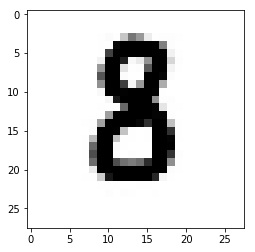

Nearest centroid:  [1]
Time:  4.003019094467163
idx=  165  pred:  0  ==WRONG==, actual label:  8


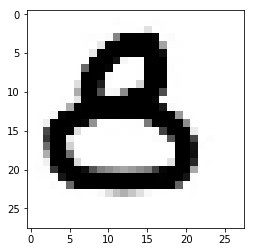

Nearest centroid:  [8]
Time:  4.974467039108276
idx=  166  # Correct:  101 pred:  8  y_test:  8
Nearest centroid:  [4]
Time:  2.7499349117279053
idx=  167  # Correct:  102 pred:  8  y_test:  8
Nearest centroid:  [6]
Time:  5.013857126235962
idx=  168  # Correct:  103 pred:  8  y_test:  8
Nearest centroid:  [1]
Time:  3.1967110633850098
idx=  169  pred:  0  ==WRONG==, actual label:  8


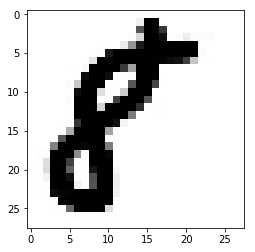

Nearest centroid:  [9]
Time:  5.20952296257019
idx=  170  # Correct:  104 pred:  8  y_test:  8
Nearest centroid:  [5]
Time:  3.6425747871398926
idx=  171  pred:  6  ==WRONG==, actual label:  8


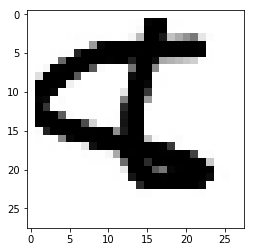

Nearest centroid:  [5]
Time:  2.884598970413208
idx=  172  pred:  6  ==WRONG==, actual label:  8


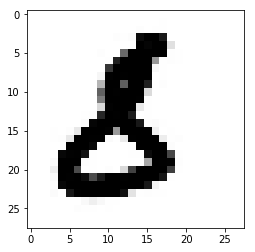

Nearest centroid:  [6]
Time:  5.127571105957031
idx=  173  # Correct:  105 pred:  8  y_test:  8
Nearest centroid:  [5]
Time:  4.143524646759033
idx=  174  pred:  6  ==WRONG==, actual label:  8


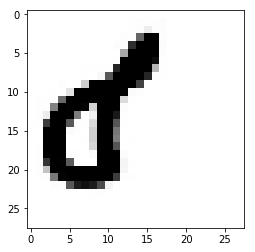

Nearest centroid:  [6]
Time:  7.160475730895996
idx=  175  # Correct:  106 pred:  8  y_test:  8
Nearest centroid:  [5]
Time:  2.8511240482330322
idx=  176  pred:  6  ==WRONG==, actual label:  8


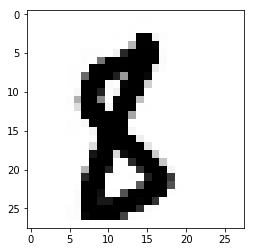

Nearest centroid:  [0]
Time:  5.798551082611084
idx=  177  pred:  0  ==WRONG==, actual label:  8


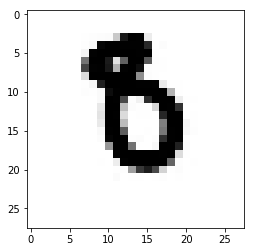

Nearest centroid:  [6]
Time:  5.995380163192749
idx=  178  # Correct:  107 pred:  8  y_test:  8
Nearest centroid:  [7]
Time:  3.990370750427246
idx=  179  # Correct:  108 pred:  8  y_test:  8
Nearest centroid:  [8]
Time:  5.3418869972229
idx=  180  pred:  3  ==WRONG==, actual label:  9


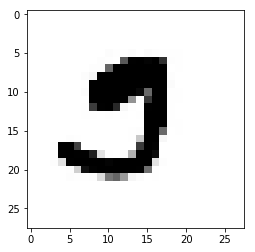

Nearest centroid:  [1]
Time:  4.461826801300049
idx=  181  # Correct:  109 pred:  9  y_test:  9
Nearest centroid:  [3]
Time:  4.803875207901001
idx=  182  pred:  3  ==WRONG==, actual label:  9


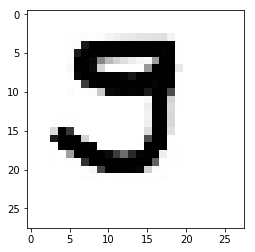

Nearest centroid:  [3]
Time:  5.018344879150391
idx=  183  pred:  3  ==WRONG==, actual label:  9


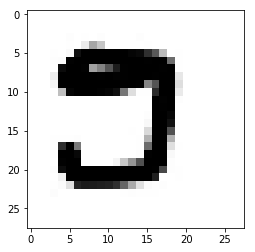

Nearest centroid:  [2]
Time:  7.713835000991821
idx=  184  pred:  8  ==WRONG==, actual label:  9


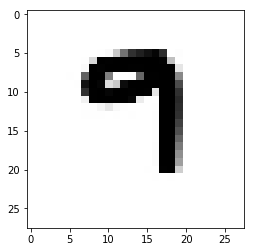

Nearest centroid:  [4]
Time:  3.912111759185791
idx=  185  # Correct:  110 pred:  9  y_test:  9
Nearest centroid:  [6]
Time:  7.695934295654297
idx=  186  pred:  3  ==WRONG==, actual label:  9


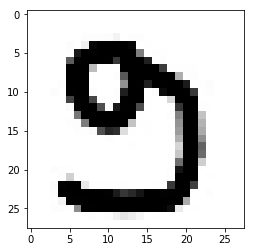

Nearest centroid:  [9]
Time:  6.616595983505249
idx=  187  # Correct:  111 pred:  9  y_test:  9
Nearest centroid:  [1]
Time:  3.9910240173339844
idx=  188  pred:  3  ==WRONG==, actual label:  9


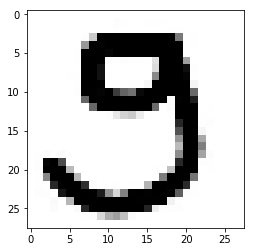

Nearest centroid:  [6]
Time:  5.168277025222778
idx=  189  # Correct:  112 pred:  9  y_test:  9
Nearest centroid:  [8]
Time:  5.454532146453857
idx=  190  pred:  3  ==WRONG==, actual label:  9


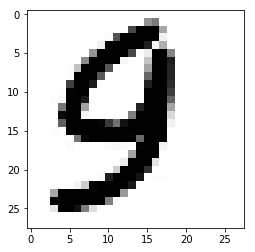

Nearest centroid:  [6]
Time:  4.387508392333984
idx=  191  # Correct:  113 pred:  9  y_test:  9
Nearest centroid:  [7]
Time:  4.037219285964966
idx=  192  # Correct:  114 pred:  9  y_test:  9
Nearest centroid:  [9]
Time:  4.417277812957764
idx=  193  # Correct:  115 pred:  9  y_test:  9
Nearest centroid:  [1]
Time:  3.632392168045044
idx=  194  # Correct:  116 pred:  9  y_test:  9
Nearest centroid:  [9]
Time:  4.607450008392334
idx=  195  # Correct:  117 pred:  9  y_test:  9
Nearest centroid:  [1]
Time:  3.1756160259246826
idx=  196  # Correct:  118 pred:  9  y_test:  9
Nearest centroid:  [0]
Time:  5.458391904830933
idx=  197  # Correct:  119 pred:  9  y_test:  9
Nearest centroid:  [9]
Time:  4.855607986450195
idx=  198  # Correct:  120 pred:  9  y_test:  9
Nearest centroid:  [8]
Time:  4.5555419921875
idx=  199  # Correct:  121 pred:  9  y_test:  9


In [971]:
correct = 0
for idx, image in enumerate(test_stack_reshape):
    pred = kmeans_knn(test_stack_reshape[idx], c, l, freeman_X_resampled, y_resampled, 10, 5)
    if test_lbl[idx] == pred:
        correct +=1
        print("idx= ",idx," # Correct: ",correct,"pred: ",pred," y_test: ", test_lbl[idx])
    else:
        print("idx= ",idx," pred: ",pred," ==WRONG==, actual label: ",test_lbl[idx])
        plt.imshow(image.reshape((28,28)), cmap=cm.binary)
        plt.show()

After running, we got 121/200 correct predictions which accounted for 60.5%

# FREQUENT SEQUENCE MINING

To mine frequent sequence, I used the `pymining` package with small modification based on the references [5, 6]. For example, if we want to find all the frequent sequences of those 2 strings: `('124','128884')` with `minimum support =2`. With the original `pymining` we will get below results:

```python
[(('1',), 2), (('1', '2'), 2), (('1', '2', '4'), 2), 
 (('1', '4'), 2), (('2',), 2), (('2', '4'), 2), (('4',), 2)]
```
If we notice that the algorithm found that `('1', '2', '4')` appears 2 times in the strings doesn't matter how many characters stay between them and this might affect our frequent sequence for digits.

By making small modification in the original code that only accept the distance to be at most `2` characters, we won't see the `('1', '2', '4')` anymore because there are more than `2` characters between `('1', '2') and ('4)`.

```python
[(('1',), 2), (('1', '2'), 2), (('2',), 2), (('4',), 2)]
```
If we change second string into `'12884'`, we will get `('1', '2', '4')` as our frequent sequence and also `('2', '4')`.

```python
[(('1',), 2), (('1', '2'), 2), (('1', '2', '4'), 2), (('2',), 2), (('2', '4'), 2), (('4',), 2)]
```

In [6]:
# Source ref: https://github.com/bartdag/pymining/blob/master/pymining/seqmining.py
# https://github.com/amschwinn/handwritten_digit_recognition/blob/master/pymining.py

def freq_seq_enum(sequences, min_support):
    freq_seqs = set()
    newseq = []
    for seq in sequences:
        newseq.append([seq])
    _freq_seq(newseq, tuple(), 0, min_support, freq_seqs,  first_round=True)
    #print("1- freq_seq_enum")
    return freq_seqs


def _freq_seq(sdb, prefix, prefix_support, min_support, freq_seqs,  first_round=False):
    #print("2", first_round)
    if prefix:
        freq_seqs.add((prefix, prefix_support))
    locally_frequents = _local_freq_items(sdb, prefix, min_support, first_round)
    if not locally_frequents:
        return
    for (item, support) in locally_frequents:
        new_prefix = prefix + (item,)
        new_sdb = _project(sdb, new_prefix,  first_round)
        _freq_seq(new_sdb, new_prefix, support, min_support, freq_seqs)


def _local_freq_items(sdb, prefix, min_support, first_round):
    #print("3", first_round)
    items = defaultdict(int)
    freq_items = []
    for entry in sdb:
        visited = set()
        for character in entry:
            j = 0
            for element in character:
                if element not in visited:
                    items[element] += 1
                    visited.add(element)
                j += 1
                if not first_round:
                    if j > 2:
                        break
    for item in items:
        support = items[item]
        if support >= min_support:
            freq_items.append((item, support))
    return freq_items


def _project(sdb, prefix,  first_round):
    #print("4", first_round)
    new_sdb = []
    if not prefix:
        return sdb
    current_prefix_item = prefix[-1]
    for entry in sdb:
        entry_proj = []
        for character in entry:
            j = 0
            for item in character:
                if item == current_prefix_item:
                    projection = character[j + 1:]
                    if projection:
                        entry_proj.append(projection)
                j += 1
                if not first_round:
                    if j > 2:
                        break
        if entry_proj:
            new_sdb.append(entry_proj)
    return new_sdb

Function to convert freeman code into tuple format that accepted by `pymining`.

In [3]:
def freeman_seq(X, mode='normal'):
    freeman_lst = []
    for i in range(X.shape[0]):
        img = X[i].reshape(28, 28)
        fml, b = fm.freeman_chain_code(np.float32(img),mode)
        fmcode = ''.join(fml)
        freeman_lst.append(fmcode)
    return tuple(freeman_lst)

In [4]:
def freq_mining(X, y, digit, min_support_thres = 0.5):
    digit_fm = freeman_seq(X[y==digit])
    total_freeman_seq = len(digit_fm)
    min_support = int(round(len(digit_fm) * min_support_thres))
    freq_seqs = freq_seq_enum(digit_fm, min_support)
    return freq_seqs

In [131]:
freeman_X_resampled = np.load('freeman_X_resampled.npy')

In [1339]:
for i in range(10):
    print("class: ",i,len(y_resampled[y_resampled==i]))

class:  0 201
class:  1 56
class:  2 240
class:  3 791
class:  4 160
class:  5 109
class:  6 284
class:  7 116
class:  8 804
class:  9 276


The running time of the algorithm will be very long if we run it on the original dataset, to save the hassle I ran it on the condensed dataset. Output will be save in `pickle` file for later use. It depends on the number of examples in each digit, the `min_support_thres` and the length of the freeman code that processing time will take longer.

In [82]:
freq_seqs_zero = freq_mining(X_resampled, y_resampled, 0, min_support_thres = 0.7)
with open('./freq_seq/freq_seqs_zero.pickle', 'wb') as f:
    pickle.dump(freq_seqs_zero, f, protocol=pickle.HIGHEST_PROTOCOL)
print(len(freq_seqs_zero))

767

In [95]:
freq_seqs_one = freq_mining(X_resampled, y_resampled, 1, min_support_thres = 0.45)
print(len(freq_seqs_one))
with open('./freq_seq/freq_seqs_one.pickle', 'wb') as f:
    pickle.dump(freq_seqs_one, f, protocol=pickle.HIGHEST_PROTOCOL)

226


In [93]:
freq_seqs_two = freq_mining(X_resampled, y_resampled, 2, min_support_thres = 0.5)
with open('./freq_seq/freq_seqs_two.pickle', 'wb') as f:
    pickle.dump(freq_seqs_two, f, protocol=pickle.HIGHEST_PROTOCOL)
print(len(freq_seqs_two))

543


In [85]:
freq_seqs_three = freq_mining(X_resampled, y_resampled, 3, min_support_thres = 0.55)
print(len(freq_seqs_three))
with open('./freq_seq/freq_seqs_three.pickle', 'wb') as f:
    pickle.dump(freq_seqs_three, f, protocol=pickle.HIGHEST_PROTOCOL)

761


In [139]:
freq_seqs_four = freq_mining(X_resampled, y_resampled, 4, min_support_thres = 0.5)
print(len(freq_seqs_four))
with open('./freq_seq/freq_seqs_four.pickle', 'wb') as f:
    pickle.dump(freq_seqs_four, f, protocol=pickle.HIGHEST_PROTOCOL)

261


In [92]:
freq_seqs_five = freq_mining(X_resampled, y_resampled, 5, min_support_thres = 0.5)
print(len(freq_seqs_five))
with open('./freq_seq/freq_seqs_five.pickle', 'wb') as f:
    pickle.dump(freq_seqs_five, f, protocol=pickle.HIGHEST_PROTOCOL)

377


In [88]:
freq_seqs_six = freq_mining(X_resampled, y_resampled, 6, min_support_thres = 0.65)
print(len(freq_seqs_six))
with open('freq_seqs_six.pickle', 'wb') as f:
    pickle.dump(freq_seqs_six, f, protocol=pickle.HIGHEST_PROTOCOL)

940


In [89]:
freq_seqs_seven = freq_mining(X_resampled, y_resampled, 7, min_support_thres = 0.5)
print(len(freq_seqs_seven))
with open('./freq_seq/freq_seqs_seven.pickle', 'wb') as f:
    pickle.dump(freq_seqs_seven, f, protocol=pickle.HIGHEST_PROTOCOL)

354


In [90]:
freq_seqs_eight = freq_mining(X_resampled, y_resampled, 8, min_support_thres = 0.5)
print(len(freq_seqs_eight))
with open('freq_seqs_eight.pickle', 'wb') as f:
    pickle.dump(freq_seqs_eight, f, protocol=pickle.HIGHEST_PROTOCOL)

783


In [91]:
freq_seqs_nine = freq_mining(X_resampled, y_resampled, 9, min_support_thres = 0.5)
print(len(freq_seqs_nine))
with open('./freq_seq/freq_seqs_nine.pickle', 'wb') as f:
    pickle.dump(freq_seqs_nine, f, protocol=pickle.HIGHEST_PROTOCOL)

499


## K-medois

Because the output of the frequent sequence will be at many different length and I am not interested in the small length, so I get the max length among them all to filter and keep only the sequences of that length. Sometimes, we only got one sequence has same length with max length.

With all the sequences that have the same max length, I just want to pick one of them to be the most frequent sequence of a digit, so I use `k-medoids` package to select the most center string.

Function to build the distance matrix which is the input for `k-medoids` package.

In [95]:
def kmedoid_dist_mat(X_freeman, kstrip=5):
    length = len(X_freeman)
    max_len = int(np.floor(len(max(X_freeman, key=len)))/2)
    k_strip = max_len
    dist_mat = np.zeros((length,length))
    for i in range(length):
        for j in range(length):
            if i==j: dist_mat[i][j] = 0
            else:
                if dist_mat[j][i] > 0:
                    dist_mat[i][j] = dist_mat[i][j]
                else:
                    dist = ed.edit_distance(X_freeman[i], X_freeman[j], kstrip).cal_distance()[0].astype(int)
                    dist_mat[i][j] = dist
                    if dist <=0:
                        print("i=", i, " j=", j," dist: ",dist)
    return dist_mat

In [96]:
# Ref: https://github.com/letiantian/kmedoids
def most_common_frequent(frequent_seq_tuple, num_cluster = 1):
    frequent_seq_list = list(frequent_seq_tuple)
    print("Total sequence: ", len(frequent_seq_list))
    # Convert frequent sequence to array
    freq_sequence = []
    for i in range(len(frequent_seq_list)):
        # Get the frequent sequence in the tuple (frequent sequence, support)
        seq = frequent_seq_list[i][0]
        seq_string = ''.join(seq)
        freq_sequence.append(seq_string)
    max_len = len(max(freq_sequence, key=len))
    new_freq_sequence = []
    for j in range(len(freq_sequence)):
        if len(freq_sequence[j]) == max_len:
            new_freq_sequence.append(freq_sequence[j])
    print(len(new_freq_sequence), new_freq_sequence)
    if len(new_freq_sequence) > 1:
        matrix = kmedoid_dist_mat(new_freq_sequence)
        medoid, _ = kmedoids.kMedoids(matrix, num_cluster)
        print("medoid", medoid)
        return new_freq_sequence[int(medoid)]
    else: return new_freq_sequence

Applying `k-medoids` on 10 digits frequence sequences:

In [141]:
freq_sequence_all = []
feq = most_common_frequent(freq_seqs_zero)
freq_sequence_all.append(feq)
feq

Total sequence:  767
4 ['4445566666700001', '4444556666700001', '4445556666700001', '4445566667000011']
medoid [3]


'4445566667000011'

In [142]:
feq = most_common_frequent(freq_seqs_one)
freq_sequence_all.append(feq)
feq

Total sequence:  226
2 ['344444444444', '444444444444']
medoid [1]


'444444444444'

In [143]:
feq = most_common_frequent(freq_seqs_two)
freq_sequence_all.append(feq)
feq

Total sequence:  543
6 ['5666667001', '6666666701', '6666667001', '6666667011', '5666666701', '6666666670']
medoid [5]


'6666666670'

In [144]:
feq = most_common_frequent(freq_seqs_three)
freq_sequence_all.append(feq)
feq

Total sequence:  761
7 ['444555666667', '444556666667', '344455666666', '444455666667', '344556666667', '344455666667', '344456666667']
medoid [6]


'344456666667'

In [145]:
feq = most_common_frequent(freq_seqs_four)
freq_sequence_all.append(feq)
feq

Total sequence:  261
2 ['4444445', '4444444']
medoid [1]


'4444444'

In [146]:
feq = most_common_frequent(freq_seqs_five)
freq_sequence_all.append(feq)
feq

Total sequence:  377
18 ['44445566', '44566667', '44455666', '44556667', '44456666', '44456667', '45566666', '44445666', '34456667', '33444566', '33445666', '44556666', '34445666', '34455666', '34445566', '34444566', '34456666', '33445566']
medoid [17]


'33445566'

In [147]:
feq = most_common_frequent(freq_seqs_six)
freq_sequence_all.append(feq)
feq

Total sequence:  940
24 ['44556666700001', '56666700000111', '34455666670000', '44556667000011', '56666700001011', '34455666700001', '55666700000111', '44566667000001', '56667000010111', '56666700001111', '56667000001011', '55666700001111', '34456666700001', '45566670000111', '44566667000011', '45666670000111', '66670000001111', '56667000001111', '45666670000011', '56666700000011', '45566670000011', '45566667000001', '45566667000011', '56667000000111']
medoid [23]


'56667000000111'

In [148]:
feq = most_common_frequent(freq_seqs_seven)
freq_sequence_all.append(feq)
feq

Total sequence:  354
2 ['222223444', '222234444']
medoid [1]


'222234444'

In [149]:
feq = most_common_frequent(freq_seqs_eight)
freq_sequence_all.append(feq)
feq

Total sequence:  783
12 ['445566667001', '444556667001', '444566670000', '445566667000', '444456666700', '444456667000', '444566667000', '444556666700', '445566670000', '444556667000', '445666670000', '444566667001']
medoid [11]


'444566667001'

In [150]:
feq = most_common_frequent(freq_seqs_nine)
freq_sequence_all.append(feq)
feq

Total sequence:  499
8 ['34444444445', '23444444444', '34444444444', '22234444444', '22344444444', '22234444445', '22344444445', '23444444445']
medoid [7]


'23444444445'

In [152]:
with open('./freq_seq/freq_sequence_all.pickle', 'wb') as f:
    pickle.dump(freq_sequence_all, f, protocol=pickle.HIGHEST_PROTOCOL)
len(freq_sequence_all), freq_sequence_all

(10,
 ['4445566667000011',
  '444444444444',
  '6666666670',
  '344456666667',
  '4444444',
  '33445566',
  '56667000000111',
  '222234444',
  '444566667001',
  '23444444445'])

In [90]:
#with open('./freq_seq/freq_sequence_all.pickle', 'rb') as f:
#    freq_sequence_all_load = pickle.load(f)

## Display frequent sequence on test example

Once we have the most frequent sequence for each digit, we need to display them on our test digit. In reality, we rarely find the exact frequent sequence on our test digit. To tackle that, I will find only the most similar one by using the package `fuzzywuzzy` and keep the most similar string to show on test digit.

In [91]:
def find_subseq_match(freeman_code, freq_sequence, freeman_boundaries):
    i = len(freeman_code)
    j = len(freq_sequence)
    index = -1
    max_sim = 0
    max_sim_fm = ""
    sub_boundaries = []
    if i < j: return 0, 0, freeman_code
    else:
        for k in range(0, i-j):
            sub = freeman_code[k:k+j]
            bound_sub = freeman_boundaries[k:k+j]
            #print(sub)
            sim = fuzz.ratio(freq_sequence, sub)
            if  sim > max_sim: 
                max_sim = sim
                #print(max_sim)
                index = k
                #print(k)
                max_sim_fm = sub
                #print(max_sim_fm)
                sub_boundaries = bound_sub
            #print("sim", sim, "max_sim", max_sim, "index", index)
    return index, max_sim, sub_boundaries, max_sim_fm

In [92]:
fq_test = freq_sequence_all_load[6]
fq_test

'56667000000111'

In [97]:
test_5 = X_resampled[y_resampled==6]
f_code, f_b = fm.freeman_chain_code(np.float32(test_5[17].reshape((28,28))))
fm_code = ''.join(f_code)
fm_code

'24444454444443432100112233344545666666777700700010000100'

In [98]:
index, max_sim, sub_boundaries, max_sim_fm = find_subseq_match(fm_code, fq_test, f_b)
index, max_sim, sub_boundaries, max_sim_fm

(35,
 71,
 [(20, 16),
  (20, 15),
  (20, 14),
  (20, 13),
  (19, 12),
  (18, 11),
  (17, 10),
  (16, 9),
  (15, 9),
  (14, 9),
  (13, 8),
  (12, 8),
  (11, 8),
  (10, 8)],
 '66677770070001')

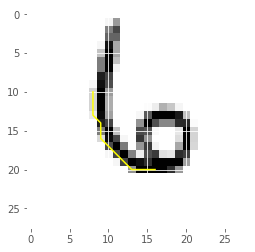

In [99]:
fmn.plot_boundaries(test_5[17].reshape((28,28)), sub_boundaries)

# REFERENCES

1. Shuhei Kishi, Speed up naive kNN by the concept of kmeans - http://marubon-ds.blogspot.com/2017/08/speed-up-naive-knn-by-concept-of-kmeans.html
- McBurger, Freeman Chain code, Second attempt - https://www.kaggle.com/mburger/freeman-chain-code-second-attempt
- McBurger, Freeman Chain code - https://www.kaggle.com/mburger/freeman-chain-code-script
- Letiantian, K-medoids - https://github.com/letiantian/kmedoids
- Barthelemy Dagenais, Pymining - https://github.com/bartdag/pymining/blob/master/pymining/seqmining.py
- Austin Schwinn, Pymining - https://github.com/amschwinn/handwritten_digit_recognition/blob/master/pymining.py
- Jake VanderPlas, Python Data Science Handbook - Essential Tools for Working with Data, In Depth: k-Means Clustering- https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
- SeatGeek, Fuzzy String Matching in Python - https://github.com/seatgeek/fuzzywuzzy